# Feature selection

## 1. Introduction and Dataset Research

### 1.1 Introduction

Variable selection is essential in modern data analysis and data science. Identifying influential and informative features not only simplifies models by reducing the number of variables but also provides valuable insights into the data. Techniques such as Principal Component Analysis are commonly used for dimensionality reduction, often eliminating variables during the preprocessing stage. Alternatively, incorporating the selection procedure directly into the model fitting process via regularization constraints can offer significant advantages.

This project explores various variables selection methods; specifically, we focus on correlations, mutual information, SHAP (SHapley Additive exPlanations), Lasso, Elastic Net, and XGBoost to interpret and validate the importance of selected features. By applying these methods to a dataset of housing sale prices featuring 80 variables including 43 categorical features, we aim to discuss the underlying principles for these methods and their performance on the real-world data. The analysis provides insights into the advantages and limitations of each method in addressing different types of data and relationships, such as non-linearity, collinearity, and interactions.

### 1.2 Goals
* conduct a comparative analysis for each model's selected features
* understand how the proposed methods work on a real-world dataset with various types of features, find the best method

### 1.3 Dataset

Anna Montoya and DataCanary. House Prices - Advanced Regression Techniques. https://kaggle.com/competitions/house-prices-advanced-regression-techniques, 2016. Kaggle.

"Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home."

## 2. Exploratory data analysis and preprocessing 

In [1]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Lasso, LinearRegression, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.feature_selection import RFECV
from xgboost import XGBRegressor
import json
import warnings
warnings.filterwarnings("ignore")
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
from tqdm.notebook import tqdm
from scipy.stats import skew
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import json
import re
import pprint
import json
from collections import defaultdict

In [260]:
# the dataset
df = pd.read_csv(
    'train.csv',
    na_values=[],
    keep_default_na=False  # Prevent "None" and other default markers from being treated as NaN
)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             1460 non-null   int64 
 1   MSSubClass     1460 non-null   int64 
 2   MSZoning       1460 non-null   object
 3   LotFrontage    1460 non-null   object
 4   LotArea        1460 non-null   int64 
 5   Street         1460 non-null   object
 6   Alley          1460 non-null   object
 7   LotShape       1460 non-null   object
 8   LandContour    1460 non-null   object
 9   Utilities      1460 non-null   object
 10  LotConfig      1460 non-null   object
 11  LandSlope      1460 non-null   object
 12  Neighborhood   1460 non-null   object
 13  Condition1     1460 non-null   object
 14  Condition2     1460 non-null   object
 15  BldgType       1460 non-null   object
 16  HouseStyle     1460 non-null   object
 17  OverallQual    1460 non-null   int64 
 18  OverallCond    1460 non-null

Id  MSSubClass MSZoning LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL          65     8450   Pave    NA      Reg   
1   2          20       RL          80     9600   Pave    NA      Reg   
2   3          60       RL          68    11250   Pave    NA      IR1   
3   4          70       RL          60     9550   Pave    NA      IR1   
4   5          60       RL          84    14260   Pave    NA      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0     NA    NA          NA       0      2   
1         Lvl    AllPub  ...        0     NA    NA          NA       0      5   
2         Lvl    AllPub  ...        0     NA    NA          NA       0      9   
3         Lvl    AllPub  ...        0     NA    NA          NA       0      2   
4         Lvl    AllPub  ...        0     NA    NA          NA       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [261]:
df = df.set_index('Id') # setting the index

In [262]:
df.dtypes.value_counts() # object and int64 types

object    46
int64     34
Name: count, dtype: int64

In [263]:
df.describe()

MSSubClass        LotArea  OverallQual  OverallCond    YearBuilt  \
count  1460.000000    1460.000000  1460.000000  1460.000000  1460.000000   
mean     56.897260   10516.828082     6.099315     5.575342  1971.267808   
std      42.300571    9981.264932     1.382997     1.112799    30.202904   
min      20.000000    1300.000000     1.000000     1.000000  1872.000000   
25%      20.000000    7553.500000     5.000000     5.000000  1954.000000   
50%      50.000000    9478.500000     6.000000     5.000000  1973.000000   
75%      70.000000   11601.500000     7.000000     6.000000  2000.000000   
max     190.000000  215245.000000    10.000000     9.000000  2010.000000   

       YearRemodAdd   BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  TotalBsmtSF  ...  \
count   1460.000000  1460.000000  1460.000000  1460.000000  1460.000000  ...   
mean    1984.865753   443.639726    46.549315   567.240411  1057.429452  ...   
std       20.645407   456.098091   161.319273   441.866955   438.705324  ...   
min     1950.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%     1967.000000     0.000000     0.000000   223.000000   795.750000  ...   
50%     1994.000000   383.500000     0.000000   477.500000   991.500000  ...   
75%     2004.000000   712.250000     0.000000   808.000000  1298.250000  ...   
max     2010.000000  5644.000000  1474.000000  2336.000000  6110.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     94.244521    46.660274      21.954110     3.409589    15.060959   
std     125.338794    66.256028      61.119149    29.317331    55.757415   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    25.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000  
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890  
std      40.177307    496.123024     2.703626     1.328095   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 34 columns]

In [264]:
df[["BsmtFinType1", "BsmtFinType2"]]  # dropping this redundant feature
cols_to_drop = ["BsmtFinType2"]
df = df.drop(columns=cols_to_drop)

The dataset has N/A and null values that are mixed up with the categories of some variables. Here, we'll properly handle "N/A" and "None".

In [265]:
na_to_no_item_cols = ["Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "Fence", "MiscFeature"]
none_to_no_item_cols = ["MasVnrType"]

In [266]:
# checking if there any None in the na_to_no_item_cols columns
s = 0 
for col in na_to_no_item_cols:
    print(df[col].value_counts())
    flag = "None" in df[col].value_counts().keys()
    print(flag)
    s += int(flag)
print(s) 

Alley
NA      1369
Grvl      50
Pave      41
Name: count, dtype: int64
False
BsmtQual
TA    649
Gd    618
Ex    121
NA     37
Fa     35
Name: count, dtype: int64
False
BsmtCond
TA    1311
Gd      65
Fa      45
NA      37
Po       2
Name: count, dtype: int64
False
BsmtExposure
No    953
Av    221
Gd    134
Mn    114
NA     38
Name: count, dtype: int64
False
BsmtFinType1
Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
NA      37
Name: count, dtype: int64
False
FireplaceQu
NA    690
Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: count, dtype: int64
False
GarageType
Attchd     870
Detchd     387
BuiltIn     88
NA          81
Basment     19
CarPort      9
2Types       6
Name: count, dtype: int64
False
GarageFinish
Unf    605
RFn    422
Fin    352
NA      81
Name: count, dtype: int64
False
GarageQual
TA    1311
NA      81
Fa      48
Gd      14
Ex       3
Po       3
Name: count, dtype: int64
False
GarageCond
TA    1326
NA      81
Fa      35
Gd       9
Po       7
Ex 

In [267]:
df[none_to_no_item_cols].value_counts()

MasVnrType
None          864
BrkFace       445
Stone         128
BrkCmn         15
NA              8
Name: count, dtype: int64

In [268]:
# replacing the categorical values found with "No_item"
df[na_to_no_item_cols] = df[na_to_no_item_cols].replace("NA", "No_item")
df[none_to_no_item_cols] = df[none_to_no_item_cols].replace("None", "No_item")

In [269]:
# counting N/A
d_na = {}
for col in df.columns:
    # print(col)
    if "NA" in df[col].value_counts():
        temp = df[col].value_counts().reset_index()
        if temp.keys:
            # print(temp.loc[temp[col] == "NA"]["count"].item())
            d_na[col] = temp.loc[temp[col] == "NA"]["count"].item()
d_na

{'LotFrontage': 259,
 'MasVnrType': 8,
 'MasVnrArea': 8,
 'Electrical': 1,
 'GarageYrBlt': 81}

In [270]:
for col in d_na.keys(): # iterating over cols with N/As
    df[col] = df[col].replace("NA", np.nan)

In [271]:
df['LotFrontage'] = pd.to_numeric(df['LotFrontage'])
df['MasVnrArea'] = pd.to_numeric(df['MasVnrArea'])
df['GarageYrBlt'] = pd.to_numeric(df['GarageYrBlt'])

In [272]:
df.isna().sum().sum()

np.int64(357)

In [273]:
df.to_csv('train_prepared_for_cv.csv') # saving for later use

In [161]:
df_nulls = df.isna().sum()[df.isna().sum() > 0]

In [162]:
df_nulls

LotFrontage    259
MasVnrType       8
MasVnrArea       8
Electrical       1
GarageYrBlt     81
dtype: int64

Plotting the remaining nulls 

In [695]:
# importing the dictionaries with description of columns
with open("columns_dict.json", "r") as json_file:
    columns_dict = json.load(json_file)
with open("feature_dict.json", "r") as json_file:
    feature_dict = json.load(json_file)

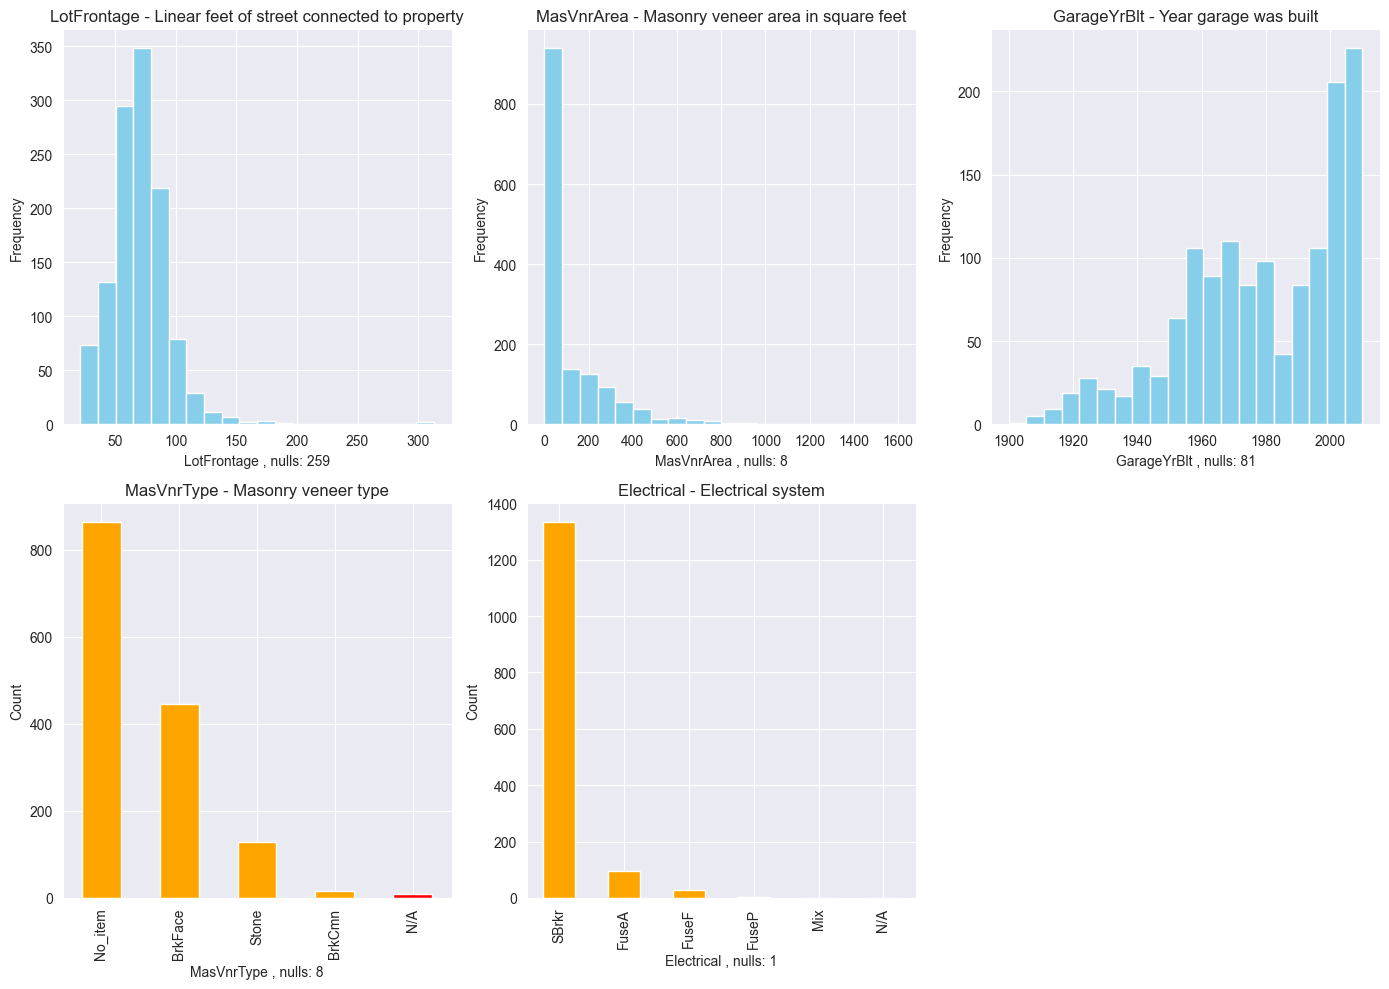

In [696]:
columns_with_nans = df.columns[df.isna().any()]
numeric_cols_with_nans = [col for col in columns_with_nans if df[col].dtype in ['int64', 'float64']]
categorical_cols_with_nans = [col for col in columns_with_nans if col not in numeric_cols_with_nans]

all_columns = numeric_cols_with_nans + categorical_cols_with_nans
num_cols = len(all_columns)

rows = ceil(num_cols / 3)
fig, axes = plt.subplots(rows, 3, figsize=(14, rows * 3 + 4))
axes = axes.flatten()

for i, col in enumerate(all_columns):
    ax = axes[i]
    title = col + " - " + columns_dict.get(col, "")
    x_label = col + " , nulls: " + str(df_nulls[col])
    if col in numeric_cols_with_nans:
        df[col].plot(kind='hist', bins=20, ax=ax, title=title, color='skyblue')
        ax.set_xlabel(x_label)
    elif col in categorical_cols_with_nans:
        value_counts = df[col].fillna("N/A").value_counts()
        colors = ["orange" if index != "N/A" else "red" for index in value_counts.index]
        value_counts.plot(kind='bar', ax=ax, title=title, color=colors)
        ax.set_xlabel(x_label)
        ax.set_ylabel("Count")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Convert year columns as the difference of the max date (2010)

In [698]:
df

MSSubClass MSZoning  LotFrontage  LotArea Street    Alley LotShape  \
Id                                                                         
1             60       RL        65.00     8450   Pave  No_item      Reg   
2             20       RL        80.00     9600   Pave  No_item      Reg   
3             60       RL        68.00    11250   Pave  No_item      IR1   
4             70       RL        60.00     9550   Pave  No_item      IR1   
5             60       RL        84.00    14260   Pave  No_item      IR1   
...          ...      ...          ...      ...    ...      ...      ...   
1456          60       RL        62.00     7917   Pave  No_item      Reg   
1457          20       RL        85.00    13175   Pave  No_item      Reg   
1458          70       RL        66.00     9042   Pave  No_item      Reg   
1459          20       RL        68.00     9717   Pave  No_item      Reg   
1460          20       RL        75.00     9937   Pave  No_item      Reg   

     LandContour Utilities LotConfig  ... PoolArea   PoolQC    Fence  \
Id                                    ...                              
1            Lvl    AllPub    Inside  ...        0  No_item  No_item   
2            Lvl    AllPub       FR2  ...        0  No_item  No_item   
3            Lvl    AllPub    Inside  ...        0  No_item  No_item   
4            Lvl    AllPub    Corner  ...        0  No_item  No_item   
5            Lvl    AllPub       FR2  ...        0  No_item  No_item   
...          ...       ...       ...  ...      ...      ...      ...   
1456         Lvl    AllPub    Inside  ...        0  No_item  No_item   
1457         Lvl    AllPub    Inside  ...        0  No_item    MnPrv   
1458         Lvl    AllPub    Inside  ...        0  No_item    GdPrv   
1459         Lvl    AllPub    Inside  ...        0  No_item  No_item   
1460         Lvl    AllPub    Inside  ...        0  No_item  No_item   

     MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                                           
1        No_item       0      2    2008        WD         Normal     208500  
2        No_item       0      5    2007        WD         Normal     181500  
3        No_item       0      9    2008        WD         Normal     223500  
4        No_item       0      2    2006        WD        Abnorml     140000  
5        No_item       0     12    2008        WD         Normal     250000  
...          ...     ...    ...     ...       ...            ...        ...  
1456     No_item       0      8    2007        WD         Normal     175000  
1457     No_item       0      2    2010        WD         Normal     210000  
1458        Shed    2500      5    2010        WD         Normal     266500  
1459     No_item       0      4    2010        WD         Normal     142125  
1460     No_item       0      6    2008        WD         Normal     147500  

[1460 rows x 79 columns]

In [699]:
year_columns = ['YearBuilt', 'YrSold', 'GarageYrBlt', 'YearRemodAdd', 'YearRemodAdd']
for col in year_columns:
    df[col] = 2010 - df[col]

Now let's fill these values with medians for numerical features and modes for categorical

In [700]:
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())
df['MasVnrType'] = df['MasVnrType'].fillna(df['MasVnrType'].mode()[0])
df['MasVnrArea'] = df['MasVnrArea'].fillna(df['MasVnrArea'].median())

For ordinal features we fill with -1 because it's supposed to work better than 0 for linear models

In [701]:
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(-1) 
df['Electrical'] = df['Electrical'].fillna(df['MasVnrArea'].median())

In [702]:
df.isna().any().sum() # no columns have nans

np.int64(0)

We eliminate abnormal observations for SalePrice

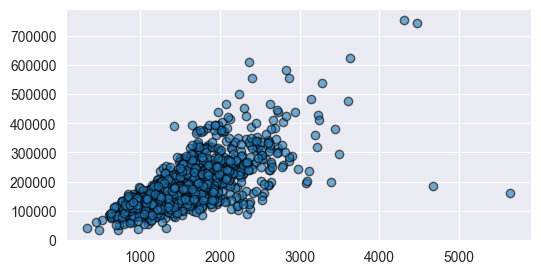

In [703]:
plt.figure(figsize=(6, 3))
plt.scatter(df['GrLivArea'], df['SalePrice'], alpha=0.6, edgecolor='k')

In [704]:
df = df[df.GrLivArea < 4000] # eliminate above 4000 sq. feet

Saving the data frame for later use.

In [705]:
# df.to_csv('train_preprocessed.csv')

Let's look at the dist of numerical features. It will help us identify for which features we might use log (or Box Cox) transformation.

In [706]:
numeric_cols = [col for col in df.columns if df[col].dtype in ['int64', 'float64']]
numeric_cols.remove("MSSubClass")
numeric_cols.remove("OverallQual")
numeric_cols.remove("OverallCond")

categorical_cols = [col for col in df.columns if col not in numeric_cols]
ordinal_encode_cols = ["OverallQual", "OverallCond", "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure", "HeatingQC", "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "PoolQC", "Street", "Alley", "PavedDrive"]
label_encode_cols = [col for col in categorical_cols if col not in ordinal_encode_cols]
ohe_encode_cols = label_encode_cols

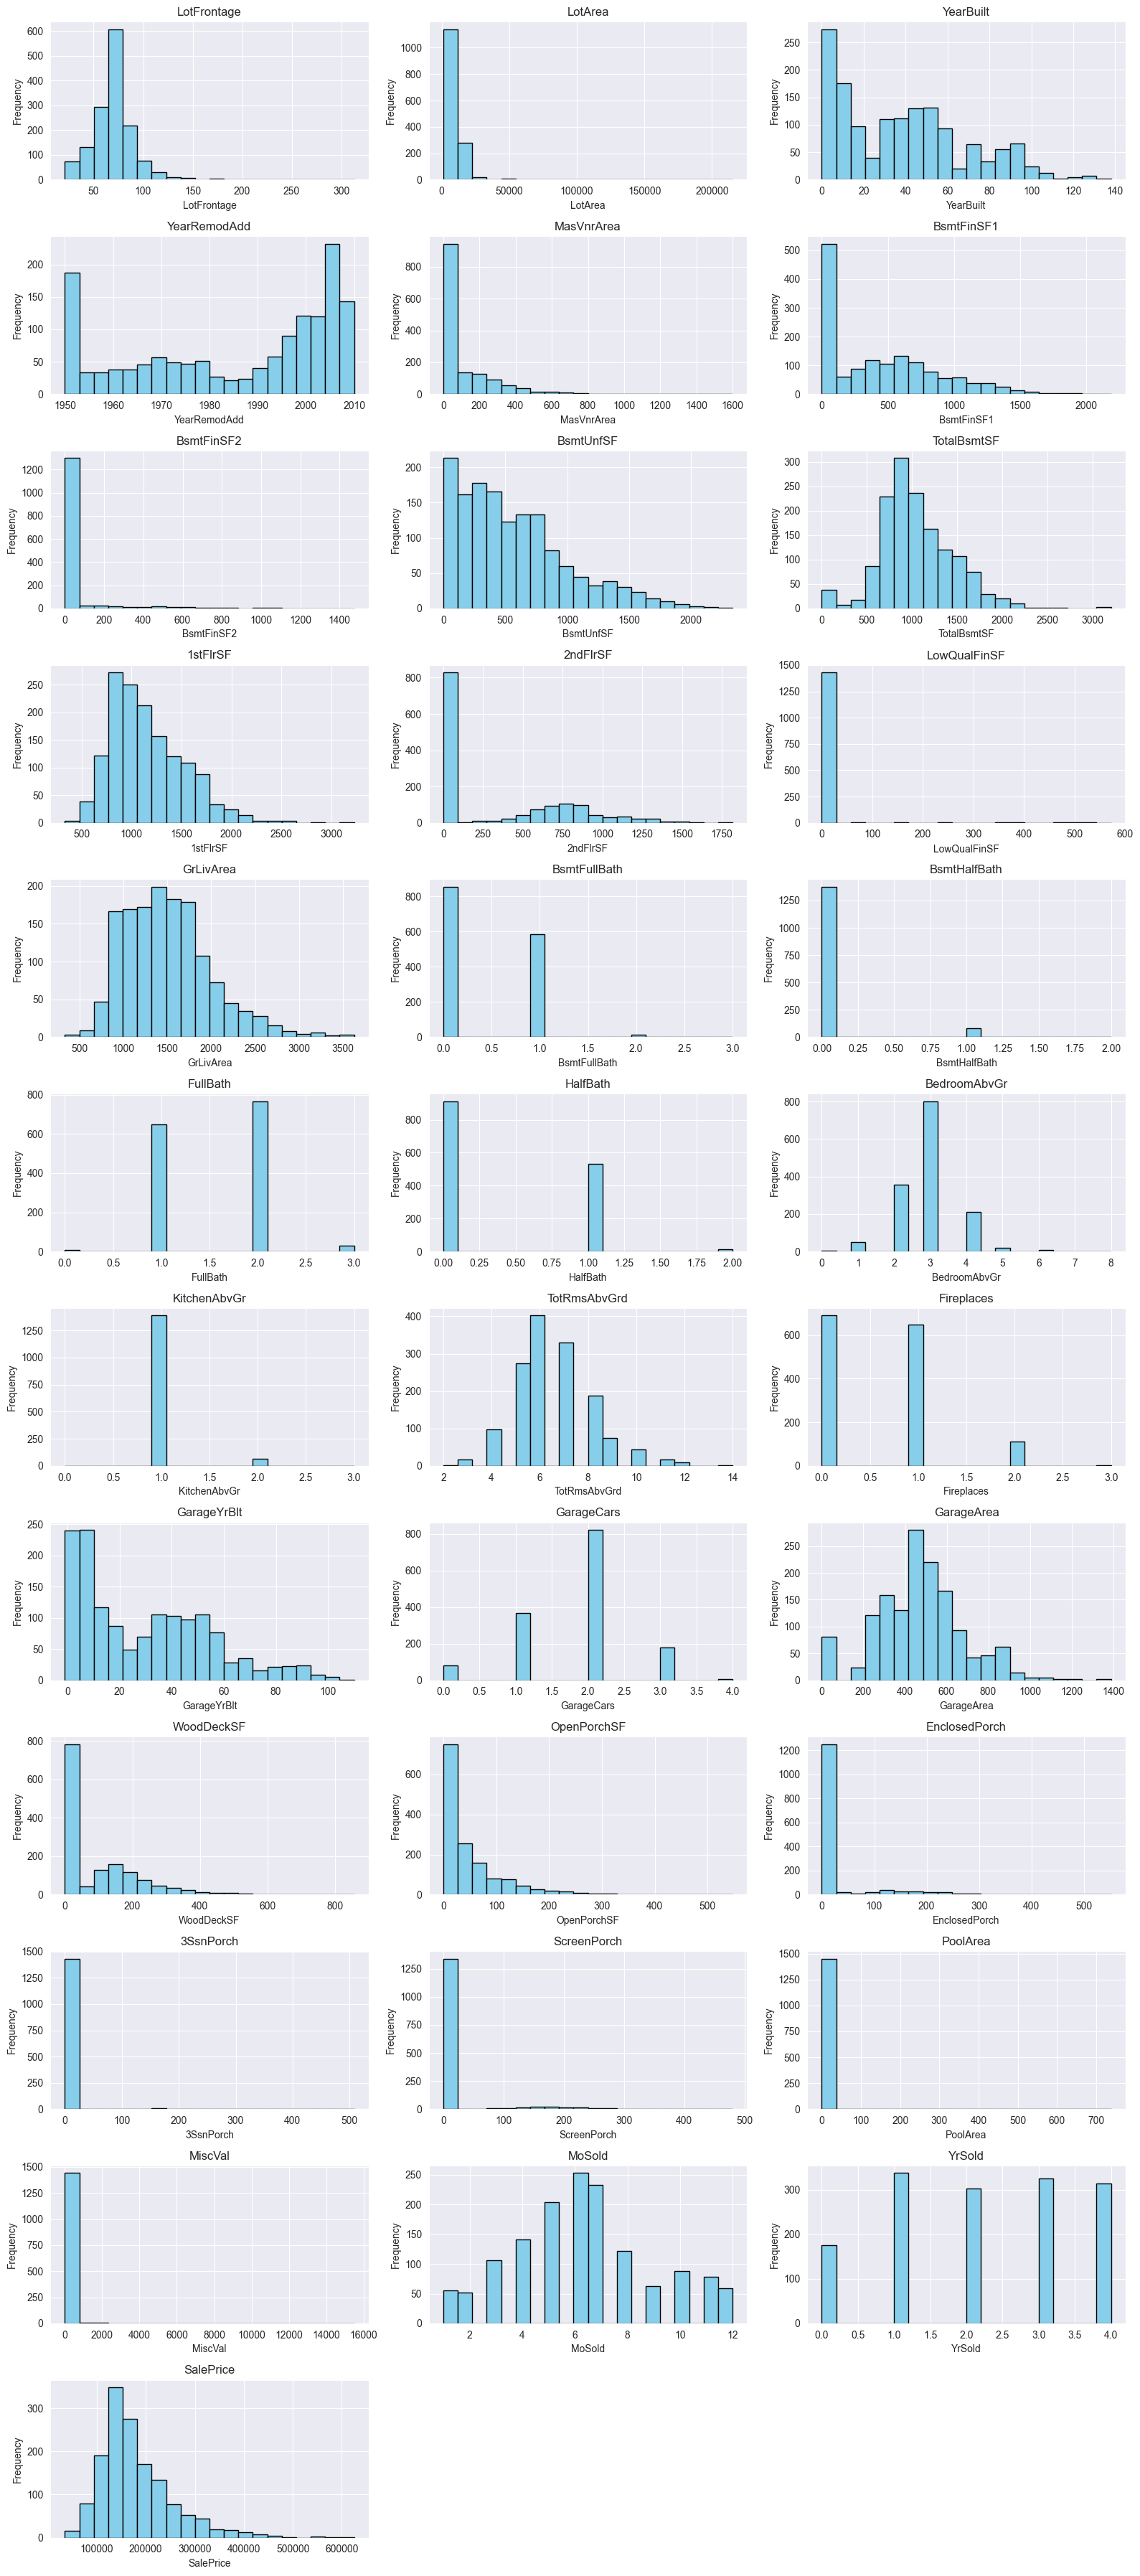

In [707]:
num_plots = len(numeric_cols)
cols = 3
rows = ceil(num_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 3))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    df[col].plot(kind='hist', bins=20, ax=axes[i], title=col, color='skyblue', edgecolor='black')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

We see quite a lot of highly skewed distributions. Would the log transformation help?

Lets create boxplots for numerical features

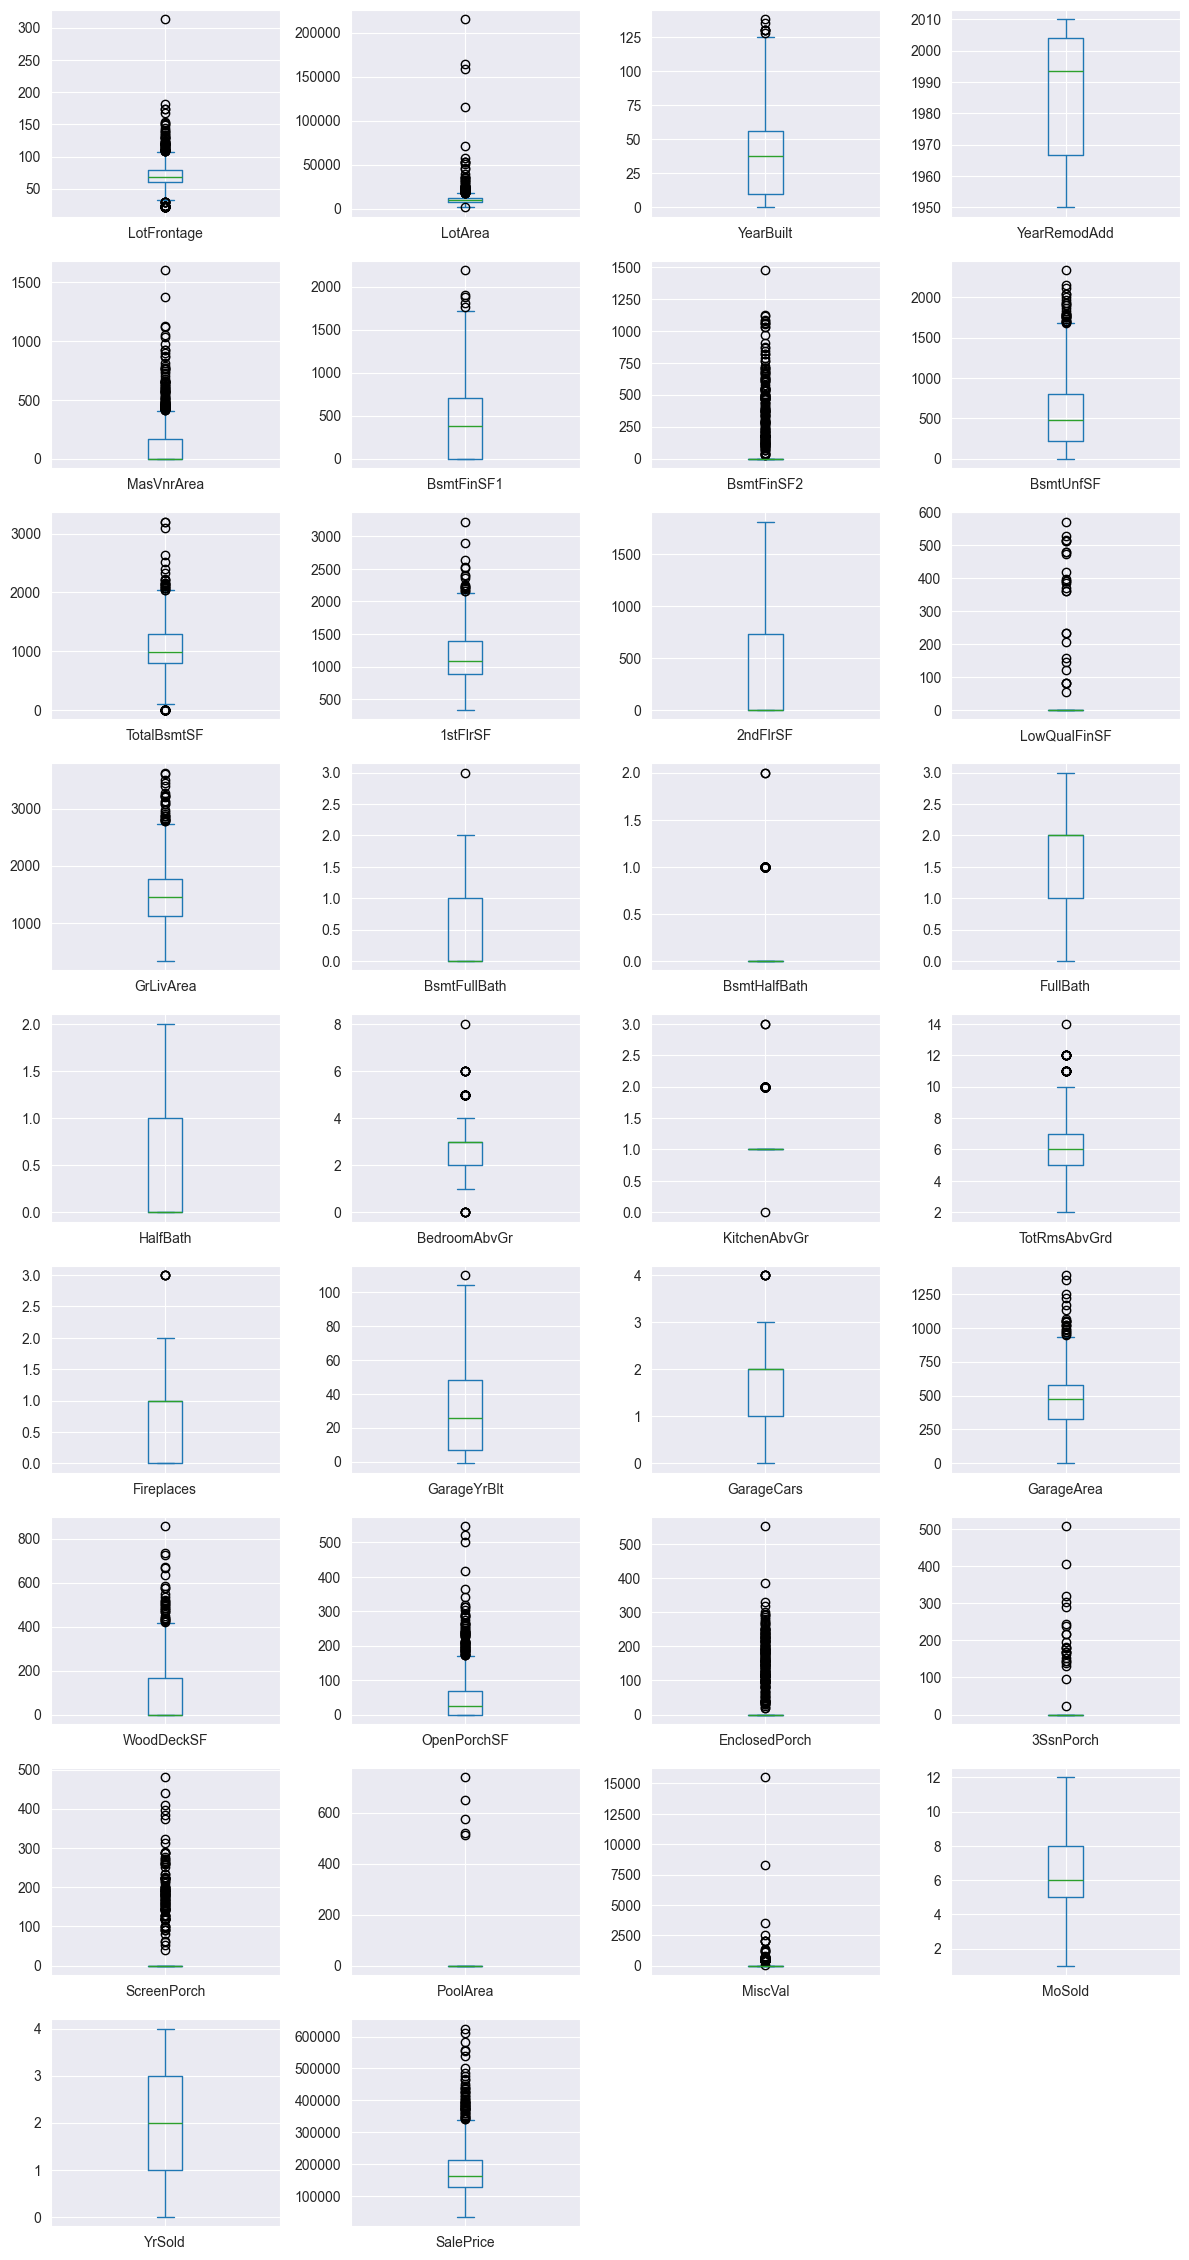

In [708]:
df[numeric_cols].plot(subplots=True, layout=(12,4), kind='box', figsize=(12, 30))
plt.tight_layout()
plt.show()

We can see that some of the features have quite a lot of extreme values. We don't want to completely eliminate them because they might contain important information and are not essentially outliers.
We want to know would we benefit from log transformation. In theory, for such models as LinearRegression, SVM (being metric-based), we may benefit from applying log transformation. We should try:
1. Transform year variables to the "how many years ago something happened". 
2. log-transform highly skewed numerical variables
3. Transform target SalePrice
 The columns to consider for these transformations: 

In [709]:
skewness = df[numeric_cols].apply(lambda x: skew(x))
skewness.sort_values(ascending=False)

MiscVal         24.42
PoolArea        17.50
LotArea         12.57
3SsnPorch       10.28
LowQualFinSF     8.99
KitchenAbvGr     4.48
BsmtFinSF2       4.24
BsmtHalfBath     4.12
ScreenPorch      4.11
EnclosedPorch    3.08
MasVnrArea       2.65
OpenPorchSF      2.34
LotFrontage      1.71
SalePrice        1.56
WoodDeckSF       1.55
BsmtUnfSF        0.92
1stFlrSF         0.87
GrLivArea        0.83
2ndFlrSF         0.78
BsmtFinSF1       0.74
HalfBath         0.68
GarageYrBlt      0.67
TotRmsAbvGrd     0.66
Fireplaces       0.63
YearBuilt        0.61
BsmtFullBath     0.59
TotalBsmtSF      0.49
MoSold           0.22
BedroomAbvGr     0.21
GarageArea       0.13
FullBath         0.02
YrSold          -0.09
GarageCars      -0.34
YearRemodAdd    -0.50
dtype: float64

In [710]:
features_with_high_skewness = list(skewness[abs(skewness) > 1].index)
# features_with_high_skewness = numeric_cols

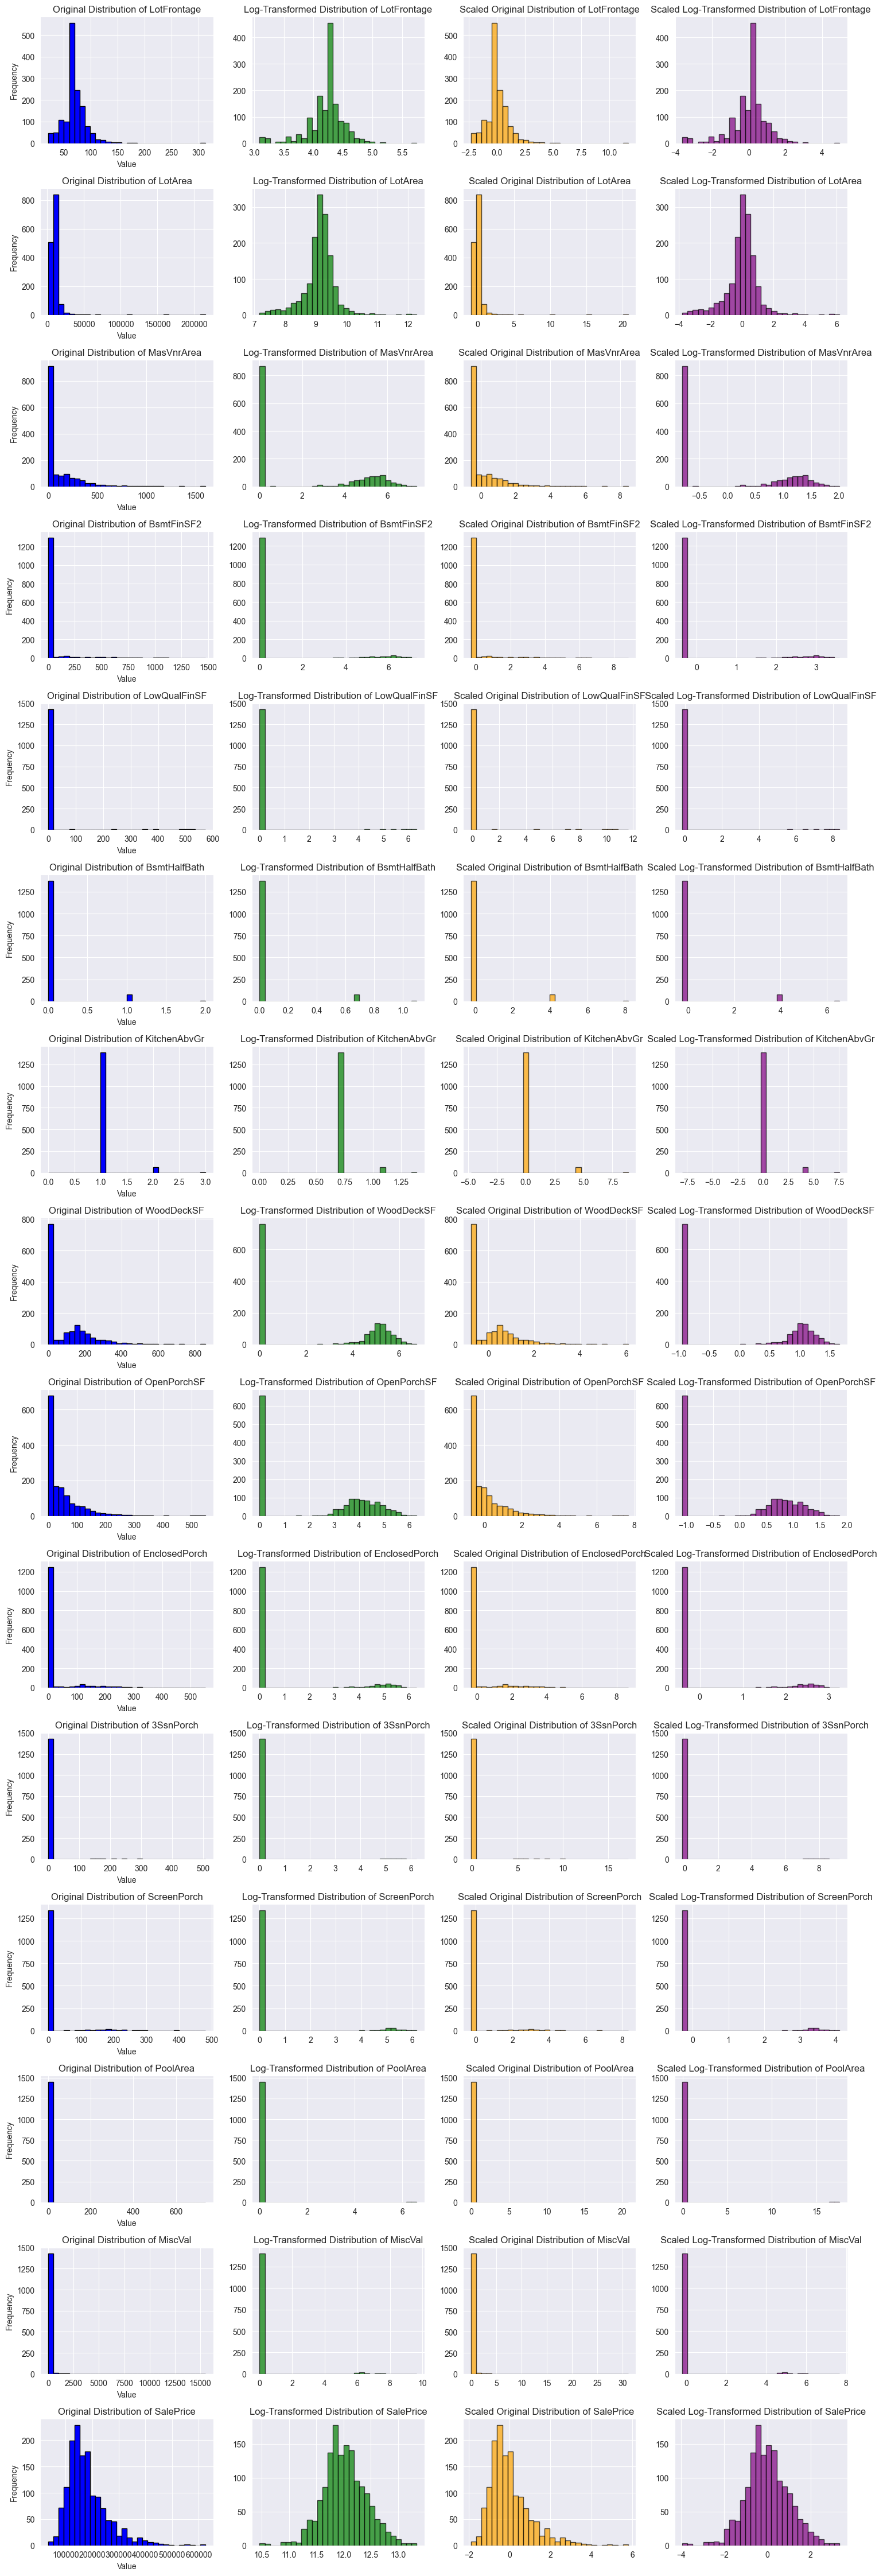

In [711]:
fig, axes = plt.subplots(len(features_with_high_skewness), 4, figsize=(15, 3 * len(features_with_high_skewness)))

scaler = StandardScaler()

for i, feature in enumerate(features_with_high_skewness):
    # Original
    axes[i, 0].hist(df[feature], bins=30, color="blue", edgecolor="black")
    axes[i, 0].set_title(f"Original Distribution of {feature}")
    axes[i, 0].set_xlabel("Value")
    axes[i, 0].set_ylabel("Frequency")

    # Log-Transformed
    if (df[feature] >= 0).all():
        log_transformed = np.log1p(df[feature])
        axes[i, 1].hist(log_transformed, bins=30, color="green", edgecolor="black", alpha=0.7)
        axes[i, 1].set_title(f"Log-Transformed Distribution of {feature}")
    else:
        axes[i, 1].set_title(f"{feature} contains non-positive values")
        axes[i, 1].axis('off')

    # Standard Scaled original
    scaled_original = scaler.fit_transform(df[[feature]])
    axes[i, 2].hist(scaled_original, bins=30, color="orange", edgecolor="black", alpha=0.7)
    axes[i, 2].set_title(f"Scaled Original Distribution of {feature}")

    # Standard Scaled Log-Transformed
    if (df[feature] >= 0).all():
        scaled_log_transformed = scaler.fit_transform(log_transformed.values.reshape(-1, 1))
        axes[i, 3].hist(scaled_log_transformed, bins=30, color="purple", edgecolor="black", alpha=0.7)
        axes[i, 3].set_title(f"Scaled Log-Transformed Distribution of {feature}")

plt.tight_layout()
plt.show()

In [712]:
numerical_skewed_columns = ['LotFrontage', 'LotArea', 'MasVnrArea', 'MiscVal', 'PoolArea', 'ScreenPorch', '3SsnPorch', 'EnclosedPorch', 'OpenPorchSF', 'WoodDeckSF', 'LowQualFinSF', 'BsmtFinSF2']

Correlations of the target variable with numerical features

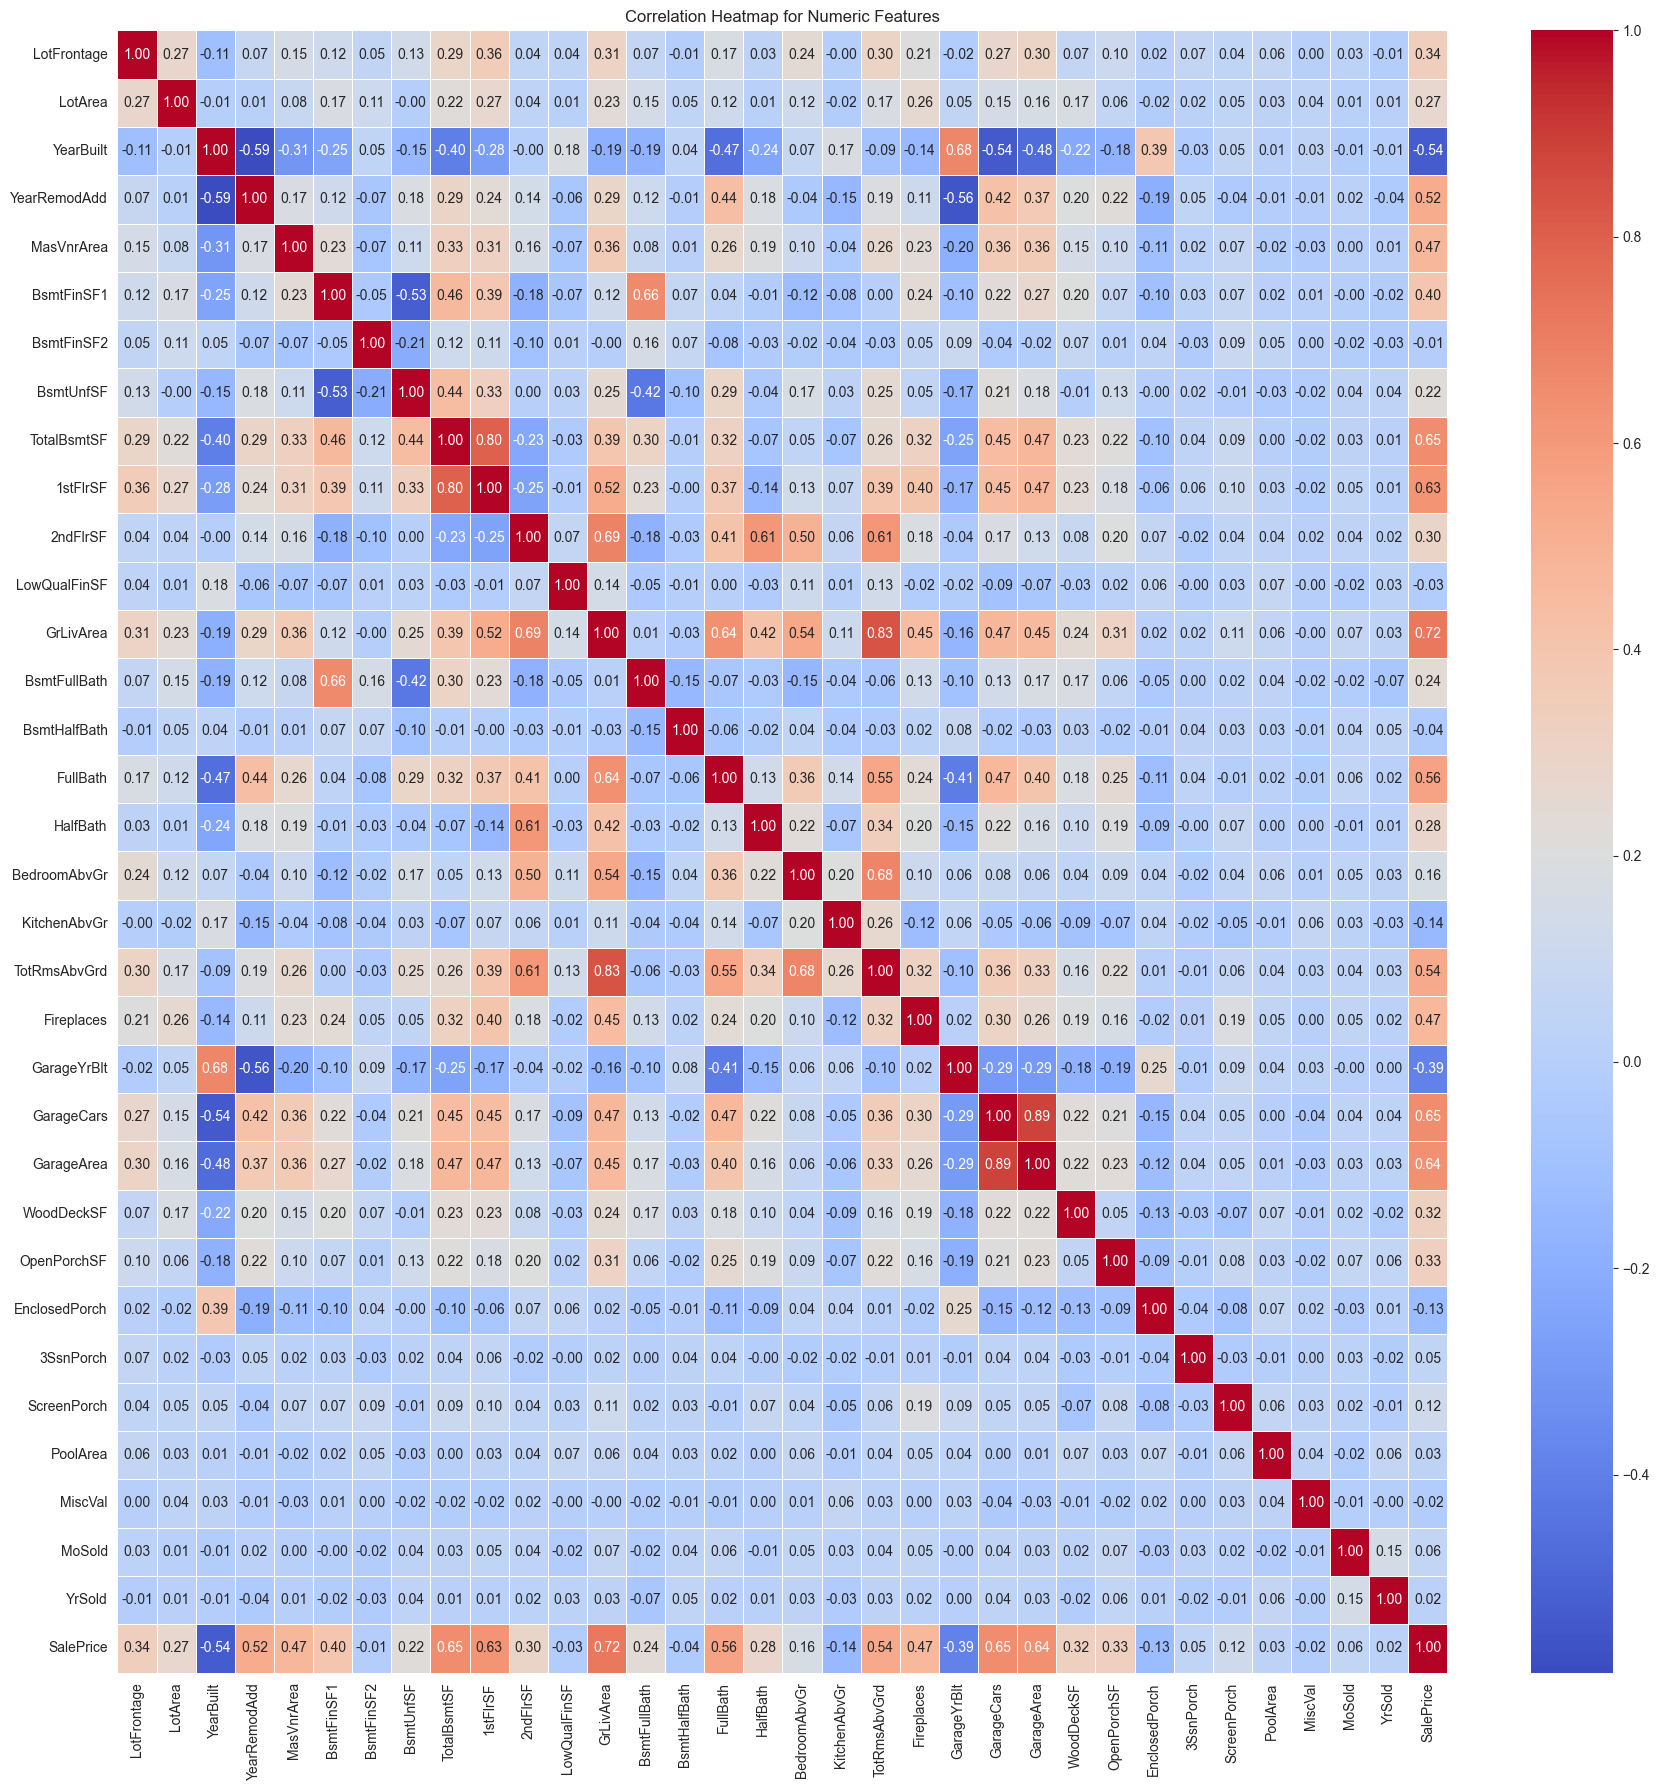

In [713]:
correlation_matrix = df[numeric_cols].corr()
plt.figure(figsize=(18, 18))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap for Numeric Features")
plt.tight_layout()
plt.show()

Finding correlations above threshold

In [714]:
threshold = 0.5

upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)

highly_correlated_pairs = upper_triangle.stack().reset_index()
highly_correlated_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
highly_correlated_pairs = highly_correlated_pairs[
    abs(highly_correlated_pairs['Correlation']) > threshold
]

In [715]:
highly_correlated_pairs.sort_values(by='Correlation', ascending=False) # high correlations above threshold

Feature 1     Feature 2  Correlation
495    GarageCars    GarageArea         0.89
336     GrLivArea  TotRmsAbvGrd         0.83
236   TotalBsmtSF      1stFlrSF         0.80
350     GrLivArea     SalePrice         0.72
286      2ndFlrSF     GrLivArea         0.69
426  BedroomAbvGr  TotRmsAbvGrd         0.68
83      YearBuilt   GarageYrBlt         0.68
162    BsmtFinSF1  BsmtFullBath         0.66
505    GarageCars     SalePrice         0.65
260   TotalBsmtSF     SalePrice         0.65
515    GarageArea     SalePrice         0.64
332     GrLivArea      FullBath         0.64
284      1stFlrSF     SalePrice         0.63
293      2ndFlrSF  TotRmsAbvGrd         0.61
290      2ndFlrSF      HalfBath         0.61
407      FullBath     SalePrice         0.56
393      FullBath  TotRmsAbvGrd         0.55
334     GrLivArea  BedroomAbvGr         0.54
469  TotRmsAbvGrd     SalePrice         0.54
263      1stFlrSF     GrLivArea         0.52
125  YearRemodAdd     SalePrice         0.52
291      2ndFlrSF  BedroomAbvGr         0.50
156    BsmtFinSF1     BsmtUnfSF        -0.53
95      YearBuilt     SalePrice        -0.54
84      YearBuilt    GarageCars        -0.54
113  YearRemodAdd   GarageYrBlt        -0.56
65      YearBuilt  YearRemodAdd        -0.59

In [716]:
highly_correlated_pairs.loc[highly_correlated_pairs['Feature 2'] == 'SalePrice', :].sort_values(by='Correlation', ascending=False) # correlation with target 

Feature 1  Feature 2  Correlation
350     GrLivArea  SalePrice         0.72
505    GarageCars  SalePrice         0.65
260   TotalBsmtSF  SalePrice         0.65
515    GarageArea  SalePrice         0.64
284      1stFlrSF  SalePrice         0.63
407      FullBath  SalePrice         0.56
469  TotRmsAbvGrd  SalePrice         0.54
125  YearRemodAdd  SalePrice         0.52
95      YearBuilt  SalePrice        -0.54

To identify which features to ordinary encode, we create these plots

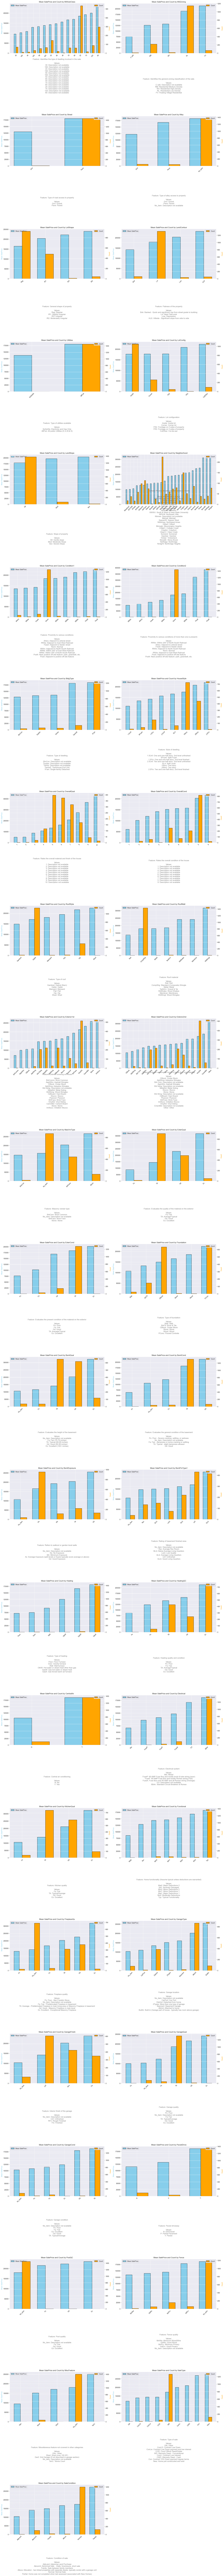

In [717]:
mean_comparison_results = {}
target_column = 'SalePrice'

num_plots = len(categorical_cols)
cols = 2
rows = ceil(num_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 10))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    category_means = df.groupby(col)[target_column].mean()
    category_counts = df[col].value_counts()
    sorted_categories = category_means.sort_values().index
    sorted_means = category_means[sorted_categories]
    sorted_counts = category_counts[sorted_categories]
    mean_comparison_results[col] = sorted_means
    x = np.arange(len(sorted_categories))

    ax1 = axes[i]
    ax2 = ax1.twinx()

    bar_width = 0.35

    ax1.bar(x - bar_width / 2, sorted_means, width=bar_width, color='skyblue', edgecolor='black', label='Mean SalePrice')
    ax2.bar(x + bar_width / 2, sorted_counts, width=bar_width, color='orange', edgecolor='black', label='Count')

    ax1.set_title(f"Mean {target_column} and Count by {col}")
    ax1.set_xticks(x)
    ax1.set_xticklabels(sorted_categories, rotation=45)
    ax1.set_ylabel("Mean SalePrice", color='skyblue')
    ax2.set_ylabel("Count", color='orange')

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    feature_description = feature_dict.get(col, {}).get("desc", "Description not available")
    value_descriptions = feature_dict.get(col, {}).get("values", {})
    sorted_value_desc_text = "\n".join(
        [f"{key}: {value_descriptions.get(key, 'Description not available')}" for key in sorted_categories]
    )

    full_description = f"Feature: {feature_description}\n\nValues:\n{sorted_value_desc_text}"

    ax1.text(
        0.5, -0.8, full_description, transform=ax1.transAxes, ha="center", fontsize=12, color="gray", wrap=True
    )

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

The columns to ordinary encode:

In [718]:
ordinal_columns = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure", "HeatingQC", "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "PoolQC", "Street", "Alley", "PavedDrive"]

We create .json file to store data about variables: their description and possible categories for categorical features

In [719]:
# # columns_dict, dict with dict with features and descriptions
# with open("columns_description.txt", "r") as file:
#     lines = file.readlines()
# 
# columns_dict = {}
# for line in lines:
#     if ": " in line:  # Ensure the line contains a key-value separator
#         key, value = line.strip().split(": ", 1)
#         columns_dict[key] = value
# 
# with open("columns_dict.json", "w") as json_file:
#     json.dump(columns_dict, json_file, indent=4)
# 
# structured_data = defaultdict(lambda: {"desc": "", "values": {}})
# 
# with open("data_description.txt", "r") as file:
#     lines = file.readlines()
# 
# current_feature = None
# 
# for line in lines:
#     feature_match = re.match(r"(\w+):\s+(.+)", line)
#     if feature_match:
#         current_feature = feature_match.group(1)
#         structured_data[current_feature]["desc"] = feature_match.group(2)
#     elif current_feature:
#         value_match = re.match(r"^\s*(\S+)\s+(.+)", line)
#         if value_match:
#             key = value_match.group(1)
#             value = value_match.group(2)
#             structured_data[current_feature]["values"][key] = value
# 
# structured_data = dict(structured_data)
# 
# with open("feature_dict.json", "w") as json_file:
#     json.dump(structured_data, json_file, indent=4)

In [720]:
encoding_mappings = {}

for col in ordinal_columns:
    if col in df.columns and col in feature_dict:
        all_values = list(feature_dict[col]["values"].keys())
        mapping = {category: rank for rank, category in enumerate(reversed(all_values), start=1)}
        mapping["No_item"] = -1
        if "NA" in mapping.keys():
            del mapping["NA"]
        encoding_mappings[col] = mapping

In [721]:
encoding_mappings

{'ExterQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1},
 'ExterCond': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1},
 'BsmtQual': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1},
 'BsmtCond': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1},
 'BsmtExposure': {'No': 2, 'Mn': 3, 'Av': 4, 'Gd': 5, 'No_item': -1},
 'HeatingQC': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1},
 'KitchenQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1},
 'FireplaceQu': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1},
 'GarageQual': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1},
 'GarageCond': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1},
 'PoolQC': {'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1},
 'Street': {'Grvl': 1, 'Pave': 2, 'No_item': -1},
 'Alley': {'Grvl': 2, 'Pave': 3, 'No_item': -1},
 'PavedDrive': {'N': 1, 'P': 2, 'Y': 3, 'No_item': -1}}

## 3. Evaluation

3.1 Importing dictionaries and data

In [2]:
with open("feature_dict.json", "r") as json_file:
    feature_dict = json.load(json_file)

In [3]:
df = pd.read_csv('train_prepared_for_cv.csv')

In [4]:
sum(df.isna().sum())

357

In [5]:
X = df.drop(columns=['Id', 'SalePrice'])
y = df['SalePrice']

In [6]:
year_columns = ['YearBuilt', 'YrSold', 'GarageYrBlt', 'YearRemodAdd', 'YearRemodAdd']
for col in year_columns:
    df[col] = 2010 - df[col]

In [7]:
numeric_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]

Features BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Fireplaces behave more like ordinal encoded features, but we will treat them as numerical features for convenience and apply standard scaling.

In [8]:
numeric_cols.remove("MSSubClass")
numeric_cols.remove("OverallQual")
numeric_cols.remove("OverallCond")
X['MSSubClass'] = X['MSSubClass'].astype(str)
X['MSZoning'] = X['MSZoning'].astype(str)
X['OverallQual'] = X['OverallQual'].astype(str)
X['OverallCond'] = X['OverallCond'].astype(str)
# X['Exterior1st'] = X['Exterior1st'].replace('WdShing', "Wd Shng")
# X['Exterior1st'] = X['Exterior1st'].replace('CemntBd', "CmentBd")
# X['Exterior2nd'] = X['Exterior2nd'].replace('WdShing', "Wd Shng")
# X['Exterior2nd'] = X['Exterior2nd'].replace('CemntBd', "CmentBd")




categorical_cols = [col for col in X.columns if col not in numeric_cols]
ordinal_encode_cols = ["OverallQual", "OverallCond", "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure", "HeatingQC", "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "PoolQC", "Street", "Alley", "PavedDrive"]
label_encode_cols = [col for col in categorical_cols if col not in ordinal_encode_cols]
ohe_encode_cols = label_encode_cols

numeric_skewed_columns = ['LotFrontage', 'LotArea', 'MasVnrArea', 'MiscVal', 'PoolArea', 'ScreenPorch', '3SsnPorch', 'EnclosedPorch', 'OpenPorchSF', 'WoodDeckSF', 'LowQualFinSF', 'BsmtFinSF2']

Numerical columns

In [9]:
print(numeric_cols)

['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


Categorical columns

In [10]:
print(categorical_cols)

['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


Ordinal columns

In [11]:
print(ordinal_encode_cols)

['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', 'Street', 'Alley', 'PavedDrive']


Label/OHE encode columns

In [12]:
print(label_encode_cols)

['MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtFinType1', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [13]:
print("# of categorical columns", len(categorical_cols))
print(f"# of ordinal: {len(ordinal_encode_cols)}, # of label: {len(label_encode_cols)}, # of ohe: {len(ohe_encode_cols)}")
print(f"# of numerical: {len(numeric_cols)}")
print(f"Total: {len(numeric_cols) + len(categorical_cols)}")
assert len(ordinal_encode_cols) + len(label_encode_cols) == len(categorical_cols)
assert len(ordinal_encode_cols) + len(ohe_encode_cols) == len(categorical_cols)

# of categorical columns 45
# of ordinal: 16, # of label: 29, # of ohe: 29
# of numerical: 33
Total: 78


### 3.2 Creating mappings for categorical columns

Since some of the columns does not have all the categories, we create mappings. It will also help us to ensure correct mappings on cross validation, so we won't miss any categories due to their absence on a particular fold.

In [14]:
ordinal_mappings = {}

for col in ordinal_encode_cols:
    if col in X.columns and col in feature_dict:
        all_values = list(feature_dict[col]["values"].keys())
        mapping = {category: rank for rank, category in enumerate(reversed(all_values), start=1)}
        mapping["No_item"] = -1
        if "NA" in mapping.keys():
            del mapping["NA"]
        ordinal_mappings[col] = mapping
        
def safe_map(value, mapping):
    if value not in mapping:
        raise ValueError(f"Value '{value}' not found in the mapping!")
    return mapping[value]

def ordinal_encode_column(X, mappings):
    encoded = X.copy()
    for col in X.columns:
        if col in mappings:
            encoded[col] = X.apply(lambda x: safe_map(x, mappings[col]))
    return encoded

print(ordinal_mappings)

{'OverallQual': {'1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, 'No_item': -1}, 'OverallCond': {'1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, 'No_item': -1}, 'ExterQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1}, 'ExterCond': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1}, 'BsmtQual': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1}, 'BsmtCond': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1}, 'BsmtExposure': {'No': 2, 'Mn': 3, 'Av': 4, 'Gd': 5, 'No_item': -1}, 'HeatingQC': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1}, 'KitchenQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1}, 'FireplaceQu': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1}, 'GarageQual': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1}, 'GarageCond': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1}, 'PoolQC': {'Fa': 2, 'TA

In [15]:
label_mappings = {}

for col in label_encode_cols:
    if col in X.columns and col in feature_dict:
        all_values = list(feature_dict[col]["values"].keys())
        mapping = {category: rank for rank, category in enumerate(reversed(all_values), start=1)}
        mapping["No_item"] = -1
        if "NA" in mapping.keys():
            del mapping["NA"]
        label_mappings[col] = mapping
        
def safe_map(value, mapping):
    if value not in mapping:
        raise ValueError(f"Value '{value}' not found in the mapping!")
    return mapping[value]

def label_encode_column(X, mappings):
    encoded = X.copy()
    for col in X.columns:
        if col in mappings:
            encoded[col] = df[col].apply(lambda x: safe_map(x, mappings[col]))
    return encoded

print(label_mappings)

{'MSSubClass': {'190': 1, '180': 2, '160': 3, '150': 4, '120': 5, '90': 6, '85': 7, '80': 8, '75': 9, '70': 10, '60': 11, '50': 12, '45': 13, '40': 14, '30': 15, '20': 16, 'No_item': -1}, 'MSZoning': {'RM': 1, 'RP': 2, 'RL': 3, 'RH': 4, 'I': 5, 'FV': 6, 'C (all)': 7, 'A': 8, 'No_item': -1}, 'LotShape': {'IR3': 1, 'IR2': 2, 'IR1': 3, 'Reg': 4, 'No_item': -1}, 'LandContour': {'Low': 1, 'HLS': 2, 'Bnk': 3, 'Lvl': 4, 'No_item': -1}, 'Utilities': {'ELO': 1, 'NoSeWa': 2, 'NoSewr': 3, 'AllPub': 4, 'No_item': -1}, 'LotConfig': {'FR3': 1, 'FR2': 2, 'CulDSac': 3, 'Corner': 4, 'Inside': 5, 'No_item': -1}, 'LandSlope': {'Sev': 1, 'Mod': 2, 'Gtl': 3, 'No_item': -1}, 'Neighborhood': {'Veenker': 1, 'Timber': 2, 'StoneBr': 3, 'Somerst': 4, 'SawyerW': 5, 'Sawyer': 6, 'SWISU': 7, 'OldTown': 8, 'NWAmes': 9, 'NridgHt': 10, 'NPkVill': 11, 'NoRidge': 12, 'NAmes': 13, 'Mitchel': 14, 'MeadowV': 15, 'IDOTRR': 16, 'Gilbert': 17, 'Edwards': 18, 'Crawfor': 19, 'CollgCr': 20, 'ClearCr': 21, 'BrkSide': 22, 'BrDale'

### 3.3 Creating functions and classes for evaluation and training

In [16]:
class DataFramePreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_cols, ordinal_cols, ohe_cols, label_cols, ordinal_mappings, label_mappings, features_to_scale, numeric_skewed_columns):
        self.numeric_cols = numeric_cols
        self.ordinal_cols = ordinal_cols
        self.ohe_cols = ohe_cols
        self.label_cols = label_cols
        self.ordinal_mappings = ordinal_mappings
        self.label_mappings = label_mappings
        self.ohe_columns_names = None
        self.medians = {}
        self.modes = {}
        self.scaler = StandardScaler()
        self.features_to_scale = features_to_scale
        self.numeric_skewed_columns = numeric_skewed_columns

    def fit(self, X, y=None):
        self.medians = X[self.numeric_cols].median()
        self.modes = X[self.ordinal_cols + self.ohe_cols + self.label_cols].mode().iloc[0]
        if self.ohe_cols:
            self.ohe_columns_names = []
            for col in self.ohe_cols:
                if col in feature_dict:
                    categories = feature_dict[col]["values"].keys()
                    for category in categories:
                        self.ohe_columns_names.append(f"{col}_{category}")
                else:
                    raise KeyError(f"Feature {col} not found in feature dictionary")
        return self

    def transform(self, X):
        X = X.copy()
        # filling NA
        for col in self.numeric_cols:
            X[col] = X[col].fillna(self.medians[col])
        
        if self.numeric_skewed_columns:
            skewness = X[self.numeric_skewed_columns].apply(lambda x: skew(x))
            skewness = skewness[abs(skewness) > 1]
            skewed_features = skewness.index
            X[skewed_features] = np.log1p(X[skewed_features])
    
        if X.columns.duplicated().any():
                raise ValueError(f"Duplicate column names found: {X.columns[X.columns.duplicated()].tolist()}")

        for col in self.ordinal_cols + self.ohe_cols + self.label_cols:
            X[col] = X[col].fillna(self.modes[col])
        
        for col in self.ordinal_cols:
            if col in self.ordinal_mappings:
                X[col] = X[col].map(self.ordinal_mappings[col])
            else:
                raise KeyError
        
        for col in self.label_cols:
            if col in self.label_mappings:
                X[col] = X[col].map(self.label_mappings[col])
            else:
                raise KeyError
        
        if self.features_to_scale:
            X[self.features_to_scale] = self.scaler.fit_transform(X[self.features_to_scale])

        
        if self.ohe_cols:
            ohe_encoded = pd.DataFrame(0, index=X.index, columns=self.ohe_columns_names)
            for col in self.ohe_cols:
                if col in feature_dict:
                    categories = feature_dict[col]["values"].keys()
                    for category in categories:
                        ohe_col_name = f"{col}_{category}"
                        ohe_encoded[ohe_col_name] = (X[col] == category).astype(int)
                else:
                    raise KeyError(f"Feature {col} not found in feature dictionary")
                
            X = X.drop(columns=self.ohe_cols)
            X = pd.concat([X, ohe_encoded], axis=1)
            
        return X

In [17]:
preprocessor = DataFramePreprocessor(
    numeric_cols=numeric_cols,
    ordinal_cols=ordinal_encode_cols,
    ohe_cols=ohe_encode_cols,
    label_cols=[],
    ordinal_mappings=ordinal_mappings,
    label_mappings=label_mappings,
    features_to_scale=numeric_cols + ordinal_encode_cols,
    numeric_skewed_columns = numeric_skewed_columns
)

In [18]:
# testing preprocessing
processed_data = preprocessor.fit_transform(X)

Initializing features that have high skewness from our previous analysis. The performance on log transformed features was worse, so we decided not to use it.

Creating a function to train and validate models on cross-validation.

In [19]:
def run_model(model_class, param_grid, preprocessor, log_target, X, y):
    
    kf = KFold(n_splits=9, shuffle=True, random_state=42)
    
    r2 = {"train": [], "test": []}
    mae = {"train": [], "test": []}
    best_params = []
    feature_importances = pd.DataFrame(index=preprocessor.fit_transform(X).columns)

    for fold, (train_index, test_index) in tqdm(enumerate(kf.split(X), 1)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        if log_target:
            y_train = np.log1p(y_train)
            y_test = np.log1p(y_test)
    
        preprocessor.fit(X_train)
        X_train_preprocessed = preprocessor.transform(X_train)
        X_test_preprocessed = preprocessor.transform(X_test)
                
        model = model_class()
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
        grid_search.fit(X_train_preprocessed, y_train)
        
        best_params.append(grid_search.best_params_)
        
        model = model_class(**grid_search.best_params_)
        model.fit(X_train_preprocessed, y_train)
        
        y_train_pred = model.predict(X_train_preprocessed)
        y_test_pred = model.predict(X_test_preprocessed)
        
        if log_target:
            y_train_pred = np.expm1(y_train_pred)
            y_test_pred = np.expm1(y_test_pred)
        
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        
        r2["train"].append(train_r2)
        r2["test"].append(test_r2)
        mae["train"].append(train_mae)
        mae["test"].append(test_mae)
        
        
        # if hasattr(model, "coef_"):
        #     print(f"Model {model_class} has coef_ attribute")
        #     print(model.coef_)
        # if hasattr(model, "feature_importances_"):
        #     print(f"Model {model_class} has feature_importances_ attribute")
        #     print(model.feature_importances_)
        
        if model_class == XGBRegressor:
            gain_importance = model.get_booster().get_score(importance_type='gain')
            fold_importances = pd.Series(gain_importance)
        else:
            if hasattr(model, "coef_"):
                try:
                    fold_importances = pd.Series(np.abs(model.coef_), index=X.columns)
                except:
                    fold_importances = pd.Series(np.abs(model.coef_), index=X_train_preprocessed.columns)

            elif hasattr(model, "feature_importances_"):    
                try:
                    fold_importances = pd.Series(model.feature_importances_, index=X.columns)
                except:
                    fold_importances = pd.Series(model.feature_importances_, index=X_train_preprocessed.columns)
            else:
                raise AttributeError(f"The model {model_class.__name__} does not support feature importance extraction.")

        common_indices = set(feature_importances.index) & set(fold_importances.index)
        if not common_indices:
            raise ValueError("No corresponding string indices found in the left DataFrame.")
        # feature_importances = pd.concat([feature_importances, fold_importances], axis=1)
        feature_importances = feature_importances.merge(fold_importances.rename(f"{fold}"), left_index=True, right_index=True, how='outer')


    feature_importances['mean_importance'] = feature_importances.mean(axis=1)
    feature_importances = feature_importances[['mean_importance']].sort_values(by='mean_importance', ascending=False)
    
    return pd.DataFrame(r2), pd.DataFrame(mae), feature_importances, best_params

### 3.4 Model evaluating

#### 3.4.1 Model performance based on scaling and encoding

Although it's a common practice to encode categorical features using One-How-Encoding and scale numerical and ordinal features for linear models like Lasso and ElasticNet, we evaluated performance of the models for different encoding of categorical features. This section explores the differences in performance based on these encodings, scaling, and log transformations of variables with high skewness and target. We explore all possible combinations.

In [20]:
import os
sys.stderr = open(os.devnull, 'w')

Creating models we will use, parameter grids, and various data preprocessors.

In [34]:
models = [LinearRegression, Lasso, ElasticNet, XGBRegressor, RandomForestRegressor]

param_grids = [
    {},
    {
        'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
    },
    {
        'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0]
    },
    {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 9],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0],
        'reg_alpha': [0, 0.5, 1],
        'reg_lambda': [0, 0.5, 1],
        'nthread': [-1],
    },
    # {
    #     'C': [10, 100, 1000, 100000, 200000, 300000],
    #     'kernel': ['rbf', 'poly'],
    #     'gamma': ['auto', 0.01, 0.1, 1, 10],
    #     'epsilon': [0, 0.1, 0.5, 1]
    #  },
    {
        'n_estimators': [300],
        'min_samples_leaf': [3, 5, 10, 20],
        'max_depth': [5, 10, 15, 20, None],
        'n_jobs': [-1],
    }
]

preprocessors = [
    # Label
    DataFramePreprocessor(
        numeric_cols=numeric_cols,
        ordinal_cols=ordinal_encode_cols,
        ohe_cols=[],
        label_cols=label_encode_cols,
        ordinal_mappings=ordinal_mappings,
        label_mappings=label_mappings,
        features_to_scale=[],
        numeric_skewed_columns = []
    ),
    DataFramePreprocessor(
        numeric_cols=numeric_cols,
        ordinal_cols=ordinal_encode_cols,
        ohe_cols=[],
        label_cols=label_encode_cols,
        ordinal_mappings=ordinal_mappings,
        label_mappings=label_mappings,
        features_to_scale=[],
        numeric_skewed_columns = numeric_skewed_columns
    ),
    DataFramePreprocessor(
        numeric_cols=numeric_cols,
        ordinal_cols=ordinal_encode_cols,
        ohe_cols=[],
        label_cols=label_encode_cols,
        ordinal_mappings=ordinal_mappings,
        label_mappings=label_mappings,
        features_to_scale=numeric_cols + ordinal_encode_cols + label_encode_cols,
        numeric_skewed_columns = []
    ),
    DataFramePreprocessor(
        numeric_cols=numeric_cols,
        ordinal_cols=ordinal_encode_cols,
        ohe_cols=[],
        label_cols=label_encode_cols,
        ordinal_mappings=ordinal_mappings,
        label_mappings=label_mappings,
        features_to_scale=numeric_cols + ordinal_encode_cols + label_encode_cols,
        numeric_skewed_columns = numeric_skewed_columns
    ),
    # OHE
    # Without scaling and log transform
    DataFramePreprocessor(
        numeric_cols=numeric_cols,
        ordinal_cols=ordinal_encode_cols,
        ohe_cols=label_encode_cols,
        label_cols=[],
        ordinal_mappings=ordinal_mappings,
        label_mappings=label_mappings,
        features_to_scale=[],
        numeric_skewed_columns = []
    ),
    # With log transform
    DataFramePreprocessor(
        numeric_cols=numeric_cols,
        ordinal_cols=ordinal_encode_cols,
        ohe_cols=label_encode_cols,
        label_cols=[],
        ordinal_mappings=ordinal_mappings,
        label_mappings=label_mappings,
        features_to_scale=[],
        numeric_skewed_columns = numeric_skewed_columns
    ),
    # With scaling
        DataFramePreprocessor(
        numeric_cols=numeric_cols,
        ordinal_cols=ordinal_encode_cols,
        ohe_cols=label_encode_cols,
        label_cols=[],
        ordinal_mappings=ordinal_mappings,
        label_mappings=label_mappings,
        features_to_scale=numeric_cols + ordinal_encode_cols,
        numeric_skewed_columns = []            
    ),
    # With log transform and scaling
        DataFramePreprocessor(
        numeric_cols=numeric_cols,
        ordinal_cols=ordinal_encode_cols,
        ohe_cols=label_encode_cols,
        label_cols=[],
        ordinal_mappings=ordinal_mappings,
        label_mappings=label_mappings,
        features_to_scale=numeric_cols + ordinal_encode_cols,
        numeric_skewed_columns = numeric_skewed_columns            
    )
]

preprocessor_descs = [{'scaling': False, 'log_transform': False, 'encoding': 'label'}, 
                      {'scaling': False, 'log_transform': True, 'encoding': 'label'}, 
                      {'scaling': True, 'log_transform': False, 'encoding': 'label'}, 
                      {'scaling': True, 'log_transform': True, 'encoding': 'label'},
                      
                      {'scaling': False, 'log_transform': False, 'encoding': 'ohe'}, 
                      {'scaling': False, 'log_transform': True, 'encoding': 'ohe'},
                      {'scaling': True, 'log_transform': False, 'encoding': 'ohe'},
                      {'scaling': True, 'log_transform': True, 'encoding': 'ohe'},
                      ]

Running for loops to do nested CV to find feature importance, hyperparameters, and properly evaluate models (R2 and MAE):

In [35]:
models_info = []
log_target_list = [False, True]
for preprocessor, preprocessor_desc in zip(preprocessors, preprocessor_descs):
    for log_target in log_target_list:
        for model, param_grid in zip(models, param_grids):
            print(model)
            print(preprocessor_desc)
            print(log_target)
            try:
                r2, mae, feature_importance, best_params = run_model(
                    model_class=model, 
                    param_grid=param_grid, 
                    preprocessor=preprocessor,
                    log_target=log_target,
                    X=X, 
                    y=y
                )
            except Exception as e:
                print(f"An unexpected error occurred: {e}")
            models_info.append(
                {
                    'model_class': model,
                    'scaling': preprocessor_desc['scaling'],
                    'encoding': preprocessor_desc['encoding'],
                    'log_transform': preprocessor_desc['log_transform'],
                    'log_target': log_target,
                    'best_params': best_params,
                    'feature_importance': feature_importance,
                    'R2': r2,
                    'MAE': mae
                }
            )
            print('-'*100)


<class 'sklearn.linear_model._base.LinearRegression'>
{'scaling': False, 'log_transform': False, 'encoding': 'label'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.Lasso'>
{'scaling': False, 'log_transform': False, 'encoding': 'label'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
{'scaling': False, 'log_transform': False, 'encoding': 'label'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'xgboost.sklearn.XGBRegressor'>
{'scaling': False, 'log_transform': False, 'encoding': 'label'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
{'scaling': False, 'log_transform': False, 'encoding': 'label'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._base.LinearRegression'>
{'scaling': False, 'log_transform': False, 'encoding': 'label'}
True


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.Lasso'>
{'scaling': False, 'log_transform': False, 'encoding': 'label'}
True


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
{'scaling': False, 'log_transform': False, 'encoding': 'label'}
True


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'xgboost.sklearn.XGBRegressor'>
{'scaling': False, 'log_transform': False, 'encoding': 'label'}
True


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
{'scaling': False, 'log_transform': False, 'encoding': 'label'}
True


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._base.LinearRegression'>
{'scaling': False, 'log_transform': True, 'encoding': 'label'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.Lasso'>
{'scaling': False, 'log_transform': True, 'encoding': 'label'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
{'scaling': False, 'log_transform': True, 'encoding': 'label'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'xgboost.sklearn.XGBRegressor'>
{'scaling': False, 'log_transform': True, 'encoding': 'label'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
{'scaling': False, 'log_transform': True, 'encoding': 'label'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._base.LinearRegression'>
{'scaling': False, 'log_transform': True, 'encoding': 'label'}
True


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.Lasso'>
{'scaling': False, 'log_transform': True, 'encoding': 'label'}
True


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
{'scaling': False, 'log_transform': True, 'encoding': 'label'}
True


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'xgboost.sklearn.XGBRegressor'>
{'scaling': False, 'log_transform': True, 'encoding': 'label'}
True


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
{'scaling': False, 'log_transform': True, 'encoding': 'label'}
True


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._base.LinearRegression'>
{'scaling': True, 'log_transform': False, 'encoding': 'label'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.Lasso'>
{'scaling': True, 'log_transform': False, 'encoding': 'label'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
{'scaling': True, 'log_transform': False, 'encoding': 'label'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'xgboost.sklearn.XGBRegressor'>
{'scaling': True, 'log_transform': False, 'encoding': 'label'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
{'scaling': True, 'log_transform': False, 'encoding': 'label'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._base.LinearRegression'>
{'scaling': True, 'log_transform': False, 'encoding': 'label'}
True


0it [00:00, ?it/s]

An unexpected error occurred: Input contains infinity or a value too large for dtype('float64').
----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.Lasso'>
{'scaling': True, 'log_transform': False, 'encoding': 'label'}
True


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
{'scaling': True, 'log_transform': False, 'encoding': 'label'}
True


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'xgboost.sklearn.XGBRegressor'>
{'scaling': True, 'log_transform': False, 'encoding': 'label'}
True


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
{'scaling': True, 'log_transform': False, 'encoding': 'label'}
True


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._base.LinearRegression'>
{'scaling': True, 'log_transform': True, 'encoding': 'label'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.Lasso'>
{'scaling': True, 'log_transform': True, 'encoding': 'label'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
{'scaling': True, 'log_transform': True, 'encoding': 'label'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'xgboost.sklearn.XGBRegressor'>
{'scaling': True, 'log_transform': True, 'encoding': 'label'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
{'scaling': True, 'log_transform': True, 'encoding': 'label'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._base.LinearRegression'>
{'scaling': True, 'log_transform': True, 'encoding': 'label'}
True


0it [00:00, ?it/s]

An unexpected error occurred: Input contains infinity or a value too large for dtype('float64').
----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.Lasso'>
{'scaling': True, 'log_transform': True, 'encoding': 'label'}
True


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
{'scaling': True, 'log_transform': True, 'encoding': 'label'}
True


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'xgboost.sklearn.XGBRegressor'>
{'scaling': True, 'log_transform': True, 'encoding': 'label'}
True


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
{'scaling': True, 'log_transform': True, 'encoding': 'label'}
True


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._base.LinearRegression'>
{'scaling': False, 'log_transform': False, 'encoding': 'ohe'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.Lasso'>
{'scaling': False, 'log_transform': False, 'encoding': 'ohe'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
{'scaling': False, 'log_transform': False, 'encoding': 'ohe'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'xgboost.sklearn.XGBRegressor'>
{'scaling': False, 'log_transform': False, 'encoding': 'ohe'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
{'scaling': False, 'log_transform': False, 'encoding': 'ohe'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._base.LinearRegression'>
{'scaling': False, 'log_transform': False, 'encoding': 'ohe'}
True


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.Lasso'>
{'scaling': False, 'log_transform': False, 'encoding': 'ohe'}
True


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
{'scaling': False, 'log_transform': False, 'encoding': 'ohe'}
True


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'xgboost.sklearn.XGBRegressor'>
{'scaling': False, 'log_transform': False, 'encoding': 'ohe'}
True


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
{'scaling': False, 'log_transform': False, 'encoding': 'ohe'}
True


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._base.LinearRegression'>
{'scaling': False, 'log_transform': True, 'encoding': 'one'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.Lasso'>
{'scaling': False, 'log_transform': True, 'encoding': 'one'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
{'scaling': False, 'log_transform': True, 'encoding': 'one'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'xgboost.sklearn.XGBRegressor'>
{'scaling': False, 'log_transform': True, 'encoding': 'one'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
{'scaling': False, 'log_transform': True, 'encoding': 'one'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._base.LinearRegression'>
{'scaling': False, 'log_transform': True, 'encoding': 'one'}
True


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.Lasso'>
{'scaling': False, 'log_transform': True, 'encoding': 'one'}
True


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
{'scaling': False, 'log_transform': True, 'encoding': 'one'}
True


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'xgboost.sklearn.XGBRegressor'>
{'scaling': False, 'log_transform': True, 'encoding': 'one'}
True


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
{'scaling': False, 'log_transform': True, 'encoding': 'one'}
True


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._base.LinearRegression'>
{'scaling': True, 'log_transform': False, 'encoding': 'one'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.Lasso'>
{'scaling': True, 'log_transform': False, 'encoding': 'one'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
{'scaling': True, 'log_transform': False, 'encoding': 'one'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'xgboost.sklearn.XGBRegressor'>
{'scaling': True, 'log_transform': False, 'encoding': 'one'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
{'scaling': True, 'log_transform': False, 'encoding': 'one'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._base.LinearRegression'>
{'scaling': True, 'log_transform': False, 'encoding': 'one'}
True


0it [00:00, ?it/s]

An unexpected error occurred: Input contains infinity or a value too large for dtype('float64').
----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.Lasso'>
{'scaling': True, 'log_transform': False, 'encoding': 'one'}
True


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
{'scaling': True, 'log_transform': False, 'encoding': 'one'}
True


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'xgboost.sklearn.XGBRegressor'>
{'scaling': True, 'log_transform': False, 'encoding': 'one'}
True


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
{'scaling': True, 'log_transform': False, 'encoding': 'one'}
True


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._base.LinearRegression'>
{'scaling': True, 'log_transform': True, 'encoding': 'one'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.Lasso'>
{'scaling': True, 'log_transform': True, 'encoding': 'one'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
{'scaling': True, 'log_transform': True, 'encoding': 'one'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'xgboost.sklearn.XGBRegressor'>
{'scaling': True, 'log_transform': True, 'encoding': 'one'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
{'scaling': True, 'log_transform': True, 'encoding': 'one'}
False


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._base.LinearRegression'>
{'scaling': True, 'log_transform': True, 'encoding': 'one'}
True


0it [00:00, ?it/s]

An unexpected error occurred: Input contains infinity or a value too large for dtype('float64').
----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.Lasso'>
{'scaling': True, 'log_transform': True, 'encoding': 'one'}
True


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
{'scaling': True, 'log_transform': True, 'encoding': 'one'}
True


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'xgboost.sklearn.XGBRegressor'>
{'scaling': True, 'log_transform': True, 'encoding': 'one'}
True


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
{'scaling': True, 'log_transform': True, 'encoding': 'one'}
True


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------


Saving to pickle:

In [100]:
import pickle
with open('CV_results.pkl', 'wb') as file:
    pickle.dump(models_info, file)

In [104]:
#### try to measure deviation of CV
keys_to_include = ['model_class', 'scaling', 'encoding', 'log_transform', 'log_target', 'R2', 'MAE', 'best_params']
filtered_dict = [{key: d[key] for key in keys_to_include} for d in models_info]

In [105]:
for d in filtered_dict:
    d['MAE_train'] = d['MAE'].mean()['train']
    d['MAE_test'] = d['MAE'].mean()['test']
    d['R2_train'] = d['R2'].mean()['train']
    d['R2_test'] = d['R2'].mean()['test']

In [106]:
keys_to_include = ['model_class', 'scaling', 'encoding', 'log_transform', 'log_target', 'R2_train', 'R2_test', 'MAE_train', 'MAE_test', 'best_params']
filtered_dict = [{key: d[key] for key in keys_to_include} for d in filtered_dict]

In [107]:
models_results = pd.DataFrame(filtered_dict)
models_results['model_class'] = models_results['model_class'].apply(lambda x: str(x).split('.')[-1].split("'")[0])

In [108]:
pd.set_option('display.float_format', '{:.2f}'.format)
models_results = models_results.sort_values(by=['model_class', 'scaling', 'encoding', 'log_transform', 'log_target'])

Best models based on MAE:

In [109]:
models_results.sort_values(by=['model_class', 'MAE_test'], ascending=[True, True]).groupby('model_class').first()

scaling encoding  log_transform  log_target  R2_train  \
model_class                                                                    
ElasticNet               False      ohe           True       False      0.91   
Lasso                    False      ohe           True       False      0.91   
LinearRegression          True    label           True        True      0.96   
RandomForestRegressor    False    label           True       False      0.96   
XGBRegressor             False      ohe          False       False      0.99   

                       R2_test  MAE_train  MAE_test  \
model_class                                           
ElasticNet                0.78   15888.62  18155.27   
Lasso                     0.78   15888.62  18155.27   
LinearRegression          0.83    8409.62  17892.46   
RandomForestRegressor     0.83    8403.95  17574.22   
XGBRegressor              0.85    6699.50  15242.14   

                                                             best_params  
model_class                                                               
ElasticNet             [{'alpha': 100, 'l1_ratio': 1.0}, {'alpha': 10...  
Lasso                  [{'alpha': 100}, {'alpha': 100}, {'alpha': 100...  
LinearRegression       [{'max_depth': None, 'min_samples_leaf': 3, 'n...  
RandomForestRegressor  [{'max_depth': 15, 'min_samples_leaf': 3, 'n_e...  
XGBRegressor           [{'learning_rate': 0.1, 'max_depth': 3, 'n_est...

Best models based on R^2:

In [110]:
models_results.sort_values(by=['model_class', 'R2_test'], ascending=[True, False]).groupby('model_class').first()

scaling encoding  log_transform  log_target  R2_train  \
model_class                                                                    
ElasticNet                True      ohe           True       False      0.91   
Lasso                     True      ohe           True       False      0.91   
LinearRegression          True    label           True        True      0.96   
RandomForestRegressor    False    label          False       False      0.96   
XGBRegressor             False      ohe          False       False      0.99   

                       R2_test  MAE_train  MAE_test  \
model_class                                           
ElasticNet                0.81   15922.52  18791.04   
Lasso                     0.81   15922.52  18791.04   
LinearRegression          0.83    8409.62  17892.46   
RandomForestRegressor     0.83    8405.34  17608.89   
XGBRegressor              0.85    6699.50  15242.14   

                                                             best_params  
model_class                                                               
ElasticNet             [{'alpha': 100, 'l1_ratio': 1.0}, {'alpha': 10...  
Lasso                  [{'alpha': 100}, {'alpha': 100}, {'alpha': 100...  
LinearRegression       [{'max_depth': None, 'min_samples_leaf': 3, 'n...  
RandomForestRegressor  [{'max_depth': 15, 'min_samples_leaf': 3, 'n_e...  
XGBRegressor           [{'learning_rate': 0.1, 'max_depth': 3, 'n_est...

It makes sense to compare models using more business-oriented metric such as MAE, the mean absolute error of price prediction.

Extracting feature importance for best models:

In [227]:
model_configs_to_extract = [
    {
    'model_class': 'ElasticNet',
    'scaling': False,
    'encoding': 'ohe',
    'log_transform': True,
    'log_target': False
    },
    {
    'model_class': 'Lasso',
    'scaling': False,
    'encoding': 'ohe',
    'log_transform': True,
    'log_target': False
    },
    {
    'model_class': 'LinearRegression',
    'scaling': True,
    'encoding': 'ohe',
    'log_transform': True,
    'log_target': True
    },
    {
    'model_class': 'RandomForestRegressor', # for this we will select ohe
    'scaling': False,
    'encoding': 'ohe',
    'log_transform': False,
    'log_target': False
    },
    {
    'model_class': 'XGBRegressor',
    'scaling': False,
    'encoding': 'ohe',
    'log_transform': False,
    'log_target': False
    }
]

models_info_copy = models_info.copy()
for model_info in models_info_copy:
    if 'model_class' in model_info:
        model_info['model_class'] = str(model_info['model_class']).split('.')[-1].split("'")[0]


filtered_models_info = {}

for model_config in model_configs_to_extract:
    for model_info in models_info_copy:
        if all(model_info[key] == value for key, value in model_config.items()):
            filtered_models_info[model_info['model_class']] = model_info['feature_importance']

 ## Observations:
 
1. LinearRegression

As we can see, Linear Regression is not a suitable model for this high-categorical data. Its performance is unstable across various data preprocessing techniques, and the model has not even converged in multiple cases, leading to an error. The resulting table also contain cases with negative R^2 indicating that model did not handle the data well. Having scaled features on the same range as binary features might cause convergence issues due to the sparse nature of binary features combined with the compressed numerical features. Third, outliers or some values of highly skewed features increase the standard deviation, which affects the scaling of all data points, making non-outlier points closer to zero. This distorts the relative relationships between data points.

The best model was obtained on label encoded features with scaling and both target and feature log-transformations, although the performance is very similar for all applied transformations, and is much worse with no transformations. We can also see that the model is overfitting since the train R^2/MAE is much larger/lower than on the test set. 

Best R^2 and MAE: 0.83 and 17892.

In [86]:
models_results[models_results['model_class'] == 'LinearRegression'].drop(columns=['best_params'])

model_class  scaling encoding  log_transform  log_target  \
0   LinearRegression    False    label          False       False   
5   LinearRegression    False    label          False        True   
10  LinearRegression    False    label           True       False   
15  LinearRegression    False    label           True        True   
40  LinearRegression    False      ohe          False       False   
45  LinearRegression    False      ohe          False        True   
50  LinearRegression    False      one           True       False   
55  LinearRegression    False      one           True        True   
20  LinearRegression     True    label          False       False   
25  LinearRegression     True    label          False        True   
30  LinearRegression     True    label           True       False   
35  LinearRegression     True    label           True        True   
60  LinearRegression     True      one          False       False   
65  LinearRegression     True      one          False        True   
70  LinearRegression     True      one           True       False   
75  LinearRegression     True      one           True        True   

           R2_train                      R2_test  MAE_train  \
0              0.85                         0.72   19231.47   
5  -236210262394.52             -298492546379.69  179383.06   
10             0.85                       -19.34   19373.43   
15 -236162550187.29             -229109558287.33  179385.68   
40             0.93                    -16644.10   14673.02   
45 -240515596196.17             -292392031774.98  180162.71   
50             0.92                        -1.15   14788.94   
55 -240367854562.01           -15795564857105.62  180152.57   
20             0.85   -5570759051425006747648.00   19234.21   
25             0.96                         0.83    8397.09   
30             0.85 -125629820036515113205760.00   19373.45   
35             0.96                         0.83    8409.62   
60             0.93   -2377787074603843584000.00   14674.45   
65             0.96                         0.83    8432.62   
70             0.92      -6589776120202737664.00   14789.07   
75             0.96                         0.83    8440.98   

              MAE_test  
0             21350.35  
5            181519.67  
10           249237.18  
15           149176.33  
40           272984.18  
45           182333.95  
50            77429.86  
55           663425.62  
20 3237216893276728.00  
25            17926.36  
30 1278487175768134.50  
35            17892.46  
60 2048316885713766.25  
65            18020.41  
70    9081728855696.86  
75            17921.89

2. Lasso

Lasso is also unstable. We can observe that it does not converge with log-transformation of the target variable.

Best R^2 and MAE are for log-transformed, ohe-encoded, and scaled features. This supports the fact that the regression models have the assumption of normally distributed data, which we satisfy more with the feature transformations.

Best R^2 and MAE: 0.78 and 15888.

Lasso tends to assign a non-zero coefficient to one or a few columns of the OHE representation while shrinking others to zero. This makes it effective for feature selection in high-dimensional categorical data because it picks the most relevant categories while ignoring redundant ones. The performance is Lasso is worse that of Linear Regression, although it uses OHE encoded features which should retain more information. As we will se later, a lot of them were eliminated by the model (with high regularization coefficient of 100, 1000), meaning that Lasso does not handle these features good (and, of course, does not handle any interactions at all). 


In [84]:
models_results[models_results['model_class'] == 'Lasso']

model_class  scaling encoding  log_transform  log_target         R2_train  \
1        Lasso    False    label          False       False             0.84   
6        Lasso    False    label          False        True -236306744886.70   
11       Lasso    False    label           True       False             0.83   
16       Lasso    False    label           True        True -235719035797.97   
41       Lasso    False      ohe          False       False             0.91   
46       Lasso    False      ohe          False        True -235386812095.82   
51       Lasso    False      one           True       False             0.91   
56       Lasso    False      one           True        True -235218687875.15   
21       Lasso     True    label          False       False             0.84   
26       Lasso     True    label          False        True -235423772532.74   
31       Lasso     True    label           True       False             0.84   
36       Lasso     True    label           True        True -235345750527.28   
61       Lasso     True      one          False       False             0.91   
66       Lasso     True      one          False        True -235063800536.77   
71       Lasso     True      one           True       False             0.91   
76       Lasso     True      one           True        True -235092538094.31   

            R2_test  MAE_train  MAE_test  \
1              0.74   19215.64  20453.11   
6  -301534349004.21  179086.75 181056.84   
11             0.75   19356.89  20432.19   
16 -289087970735.04  179240.44 181009.66   
41             0.77   15816.21  18165.08   
46 -296037686317.10  179311.14 181338.06   
51             0.78   15888.62  18155.27   
56 -282310207322.73  179299.36 181004.51   
21             0.78   19279.15  20966.65   
26 -255044616151.82  179207.61 179941.46   
31             0.78   19459.39  21142.56   
36 -252204710622.93  179215.95 179761.22   
61             0.81   15828.19  18708.44   
66 -253765654087.34  179264.34 180123.67   
71             0.81   15922.52  18791.04   
76 -251503567509.52  179280.27 179958.06   

                                          best_params  
1   [{'alpha': 1000}, {'alpha': 1000}, {'alpha': 1...  
6   [{'alpha': 0.001}, {'alpha': 0.001}, {'alpha':...  
11  [{'alpha': 1000}, {'alpha': 1000}, {'alpha': 1...  
16  [{'alpha': 0.001}, {'alpha': 0.001}, {'alpha':...  
41  [{'alpha': 100}, {'alpha': 100}, {'alpha': 100...  
46  [{'alpha': 0.001}, {'alpha': 0.001}, {'alpha':...  
51  [{'alpha': 100}, {'alpha': 100}, {'alpha': 100...  
56  [{'alpha': 0.001}, {'alpha': 0.001}, {'alpha':...  
21  [{'alpha': 1000}, {'alpha': 1000}, {'alpha': 1...  
26  [{'alpha': 0.001}, {'alpha': 0.001}, {'alpha':...  
31  [{'alpha': 1000}, {'alpha': 1000}, {'alpha': 1...  
36  [{'alpha': 0.001}, {'alpha': 0.001}, {'alpha':...  
61  [{'alpha': 100}, {'alpha': 100}, {'alpha': 100...  
66  [{'alpha': 0.001}, {'alpha': 0.001}, {'alpha':...  
71  [{'alpha': 100}, {'alpha': 100}, {'alpha': 100...  
76  [{'alpha': 0.001}, {'alpha': 0.001}, {'alpha':...

3. ElasticNet
Elastic Net performance is very similar to Lasso since l1_ratio is 1.0 or close to 1.0 is most cases.

Best R^2 and MAE: 0.78 and 15888.

In [87]:
models_results[models_results['model_class'] == 'ElasticNet']

model_class  scaling encoding  log_transform  log_target         R2_train  \
2   ElasticNet    False    label          False       False             0.84   
7   ElasticNet    False    label          False        True -236144927921.70   
12  ElasticNet    False    label           True       False             0.83   
17  ElasticNet    False    label           True        True -236034366119.92   
42  ElasticNet    False      ohe          False       False             0.91   
47  ElasticNet    False      ohe          False        True -235771600704.67   
52  ElasticNet    False      one           True       False             0.91   
57  ElasticNet    False      one           True        True -235673700146.06   
22  ElasticNet     True    label          False       False             0.84   
27  ElasticNet     True    label          False        True -232774837366.62   
32  ElasticNet     True    label           True       False             0.84   
37  ElasticNet     True    label           True        True -232658475700.96   
62  ElasticNet     True      one          False       False             0.91   
67  ElasticNet     True      one          False        True -235651077728.13   
72  ElasticNet     True      one           True       False             0.91   
77  ElasticNet     True      one           True        True -235566305002.51   

            R2_test  MAE_train  MAE_test  \
2              0.74   18942.97  20199.82   
7  -314010564120.16  179070.45 181181.42   
12             0.72   19092.20  22219.99   
17 -287620436413.75  179159.36 180758.23   
42             0.77   15816.21  18165.08   
47 -288753655310.08  179443.55 181409.09   
52             0.78   15888.62  18155.27   
57 -279524207216.74  179443.90 181165.88   
22             0.79   18988.10  20660.17   
27 -248772522977.18  178645.40 179212.44   
32             0.78   19257.68  21040.00   
37 -246041261042.29  178666.81 179048.36   
62             0.80   15864.84  18746.83   
67 -254822105527.35  179424.52 180419.45   
72             0.81   15922.52  18791.04   
77 -252972577819.25  179419.95 180256.11   

                                          best_params  
2   [{'alpha': 1, 'l1_ratio': 0.7}, {'alpha': 1, '...  
7   [{'alpha': 0.01, 'l1_ratio': 0.5}, {'alpha': 0...  
12  [{'alpha': 1, 'l1_ratio': 0.7}, {'alpha': 1, '...  
17  [{'alpha': 0.01, 'l1_ratio': 0.1}, {'alpha': 0...  
42  [{'alpha': 100, 'l1_ratio': 1.0}, {'alpha': 10...  
47  [{'alpha': 0.001, 'l1_ratio': 0.5}, {'alpha': ...  
52  [{'alpha': 100, 'l1_ratio': 1.0}, {'alpha': 10...  
57  [{'alpha': 0.001, 'l1_ratio': 0.5}, {'alpha': ...  
22  [{'alpha': 1, 'l1_ratio': 0.7}, {'alpha': 1, '...  
27  [{'alpha': 0.01, 'l1_ratio': 0.5}, {'alpha': 0...  
32  [{'alpha': 1, 'l1_ratio': 0.7}, {'alpha': 1, '...  
37  [{'alpha': 0.01, 'l1_ratio': 0.5}, {'alpha': 0...  
62  [{'alpha': 100, 'l1_ratio': 1.0}, {'alpha': 10...  
67  [{'alpha': 0.001, 'l1_ratio': 0.5}, {'alpha': ...  
72  [{'alpha': 100, 'l1_ratio': 1.0}, {'alpha': 10...  
77  [{'alpha': 0.001, 'l1_ratio': 0.5}, {'alpha': ...

4. RandomForestRegressor
Random Forests are non-parametric models that work by recursively splitting data into regions based on feature thresholds. They do not explicitly model relationships like Linear Regression, which leads to issues when we apply transformations. When the target is log-transformed, the compressed range of values may result in splits that do not align with the original target's structure. This fact is supported from the empirical results.

Best R^2 and MAE: 0.83 and 17574 on non-scaled label-encoded features with no log-transformations, although the performance across transformations except log_target is similar.

In [89]:
models_results[models_results['model_class'] == 'RandomForestRegressor']

model_class  scaling encoding  log_transform  log_target  \
4   RandomForestRegressor    False    label          False       False   
9   RandomForestRegressor    False    label          False        True   
14  RandomForestRegressor    False    label           True       False   
19  RandomForestRegressor    False    label           True        True   
44  RandomForestRegressor    False      ohe          False       False   
49  RandomForestRegressor    False      ohe          False        True   
54  RandomForestRegressor    False      one           True       False   
59  RandomForestRegressor    False      one           True        True   
24  RandomForestRegressor     True    label          False       False   
29  RandomForestRegressor     True    label          False        True   
34  RandomForestRegressor     True    label           True       False   
39  RandomForestRegressor     True    label           True        True   
64  RandomForestRegressor     True      one          False       False   
69  RandomForestRegressor     True      one          False        True   
74  RandomForestRegressor     True      one           True       False   
79  RandomForestRegressor     True      one           True        True   

           R2_train          R2_test  MAE_train  MAE_test  \
4              0.96             0.83    8405.34  17608.89   
9  -234290348792.91 -236212164683.37  179103.97 178337.37   
14             0.96             0.83    8403.95  17574.22   
19 -234252562710.62 -235076245984.25  179109.32 178266.19   
44             0.96             0.83    8438.00  17669.80   
49 -234139232554.49 -235926386958.37  179104.22 178288.43   
54             0.96             0.83    8453.92  17814.82   
59 -234119296984.47 -234305576189.24  179099.28 178084.78   
24             0.96             0.83    8397.09  17926.36   
29 -234339750166.39 -236584199721.98  179125.17 178431.19   
34             0.96             0.83    8409.62  17892.46   
39 -234269002631.38 -235914873017.86  179124.18 178363.59   
64             0.96             0.83    8432.62  18020.41   
69 -234080598390.20 -236559201838.55  179110.32 178552.07   
74             0.96             0.83    8440.98  17921.89   
79 -233973580850.47 -235528145611.77  179082.19 178368.21   

                                          best_params  
4   [{'max_depth': 15, 'min_samples_leaf': 3, 'n_e...  
9   [{'max_depth': 15, 'min_samples_leaf': 3, 'n_e...  
14  [{'max_depth': 15, 'min_samples_leaf': 3, 'n_e...  
19  [{'max_depth': 15, 'min_samples_leaf': 3, 'n_e...  
44  [{'max_depth': 15, 'min_samples_leaf': 3, 'n_e...  
49  [{'max_depth': None, 'min_samples_leaf': 3, 'n...  
54  [{'max_depth': 20, 'min_samples_leaf': 3, 'n_e...  
59  [{'max_depth': None, 'min_samples_leaf': 3, 'n...  
24  [{'max_depth': None, 'min_samples_leaf': 3, 'n...  
29  [{'max_depth': 20, 'min_samples_leaf': 3, 'n_e...  
34  [{'max_depth': None, 'min_samples_leaf': 3, 'n...  
39  [{'max_depth': 20, 'min_samples_leaf': 3, 'n_e...  
64  [{'max_depth': 20, 'min_samples_leaf': 3, 'n_e...  
69  [{'max_depth': 15, 'min_samples_leaf': 3, 'n_e...  
74  [{'max_depth': 20, 'min_samples_leaf': 3, 'n_e...  
79  [{'max_depth': 15, 'min_samples_leaf': 3, 'n_e...

5. XGBRegressor

XGBRegressor is the best performing model in terms of business metric MAE. Similar to RandomForestRegressor, it does not work on log_transformed target because it's tree-based. 

The main difference with RandomForest was that the learning process in XGBoost relies on gradients and Hessians to decide which features and splits to prioritize. These statistics can be influenced by scaling of the features. Probably, for this data, scaling of some features does not make sence and doesn't fit the data well. That's why we see bad performance with much larger MAE (~24000) and R^2 (0.77) for the run with scaled features.

Best R^2 and MAE: 0.85 and 15242. The best performance was obtained in OHE encoded features without scaling. Both R^2 and MAE are the best on this set. 

In [90]:
models_results[models_results['model_class'] == 'XGBRegressor']

model_class  scaling encoding  log_transform  log_target  \
3   XGBRegressor    False    label          False       False   
8   XGBRegressor    False    label          False        True   
13  XGBRegressor    False    label           True       False   
18  XGBRegressor    False    label           True        True   
43  XGBRegressor    False      ohe          False       False   
48  XGBRegressor    False      ohe          False        True   
53  XGBRegressor    False      one           True       False   
58  XGBRegressor    False      one           True        True   
23  XGBRegressor     True    label          False       False   
28  XGBRegressor     True    label          False        True   
33  XGBRegressor     True    label           True       False   
38  XGBRegressor     True    label           True        True   
63  XGBRegressor     True      one          False       False   
68  XGBRegressor     True      one          False        True   
73  XGBRegressor     True      one           True       False   
78  XGBRegressor     True      one           True        True   

           R2_train          R2_test  MAE_train  MAE_test  \
3              0.99             0.84    6617.76  15758.37   
8  -241761375039.86 -241504219385.11  180361.25 179073.00   
13             0.99             0.83    6617.76  16798.06   
18 -241761375039.86 -240705866550.59  180361.25 179475.06   
43             0.99             0.85    6699.50  15242.14   
48 -241828865563.93 -244117798394.20  180367.28 179590.88   
53             0.99             0.84    6699.50  16319.23   
58 -241828865563.93 -250241521331.88  180367.28 182209.80   
23             0.99             0.71    6617.76  28854.62   
28 -241761375039.86 -177312839907.59  180361.25 153939.80   
33             0.99             0.71    6617.76  28571.28   
38 -241761375039.86 -177685283581.23  180361.25 154298.94   
63             0.99             0.77    6699.50  23672.12   
68 -241828865563.93 -192903194638.25  180367.28 160992.40   
73             0.99             0.77    6699.50  23636.48   
78 -241828865563.93 -192696986320.71  180367.28 161134.69   

                                          best_params  
3   [{'learning_rate': 0.1, 'max_depth': 3, 'n_est...  
8   [{'learning_rate': 0.1, 'max_depth': 3, 'n_est...  
13  [{'learning_rate': 0.1, 'max_depth': 3, 'n_est...  
18  [{'learning_rate': 0.1, 'max_depth': 3, 'n_est...  
43  [{'learning_rate': 0.1, 'max_depth': 3, 'n_est...  
48  [{'learning_rate': 0.1, 'max_depth': 3, 'n_est...  
53  [{'learning_rate': 0.1, 'max_depth': 3, 'n_est...  
58  [{'learning_rate': 0.1, 'max_depth': 3, 'n_est...  
23  [{'learning_rate': 0.1, 'max_depth': 3, 'n_est...  
28  [{'learning_rate': 0.1, 'max_depth': 3, 'n_est...  
33  [{'learning_rate': 0.1, 'max_depth': 3, 'n_est...  
38  [{'learning_rate': 0.1, 'max_depth': 3, 'n_est...  
63  [{'learning_rate': 0.1, 'max_depth': 3, 'n_est...  
68  [{'learning_rate': 0.1, 'max_depth': 3, 'n_est...  
73  [{'learning_rate': 0.1, 'max_depth': 3, 'n_est...  
78  [{'learning_rate': 0.1, 'max_depth': 3, 'n_est...

Let's also use SHAP for best XGBoost model to extract feature importance interpretation: 

Global Feature Importance:


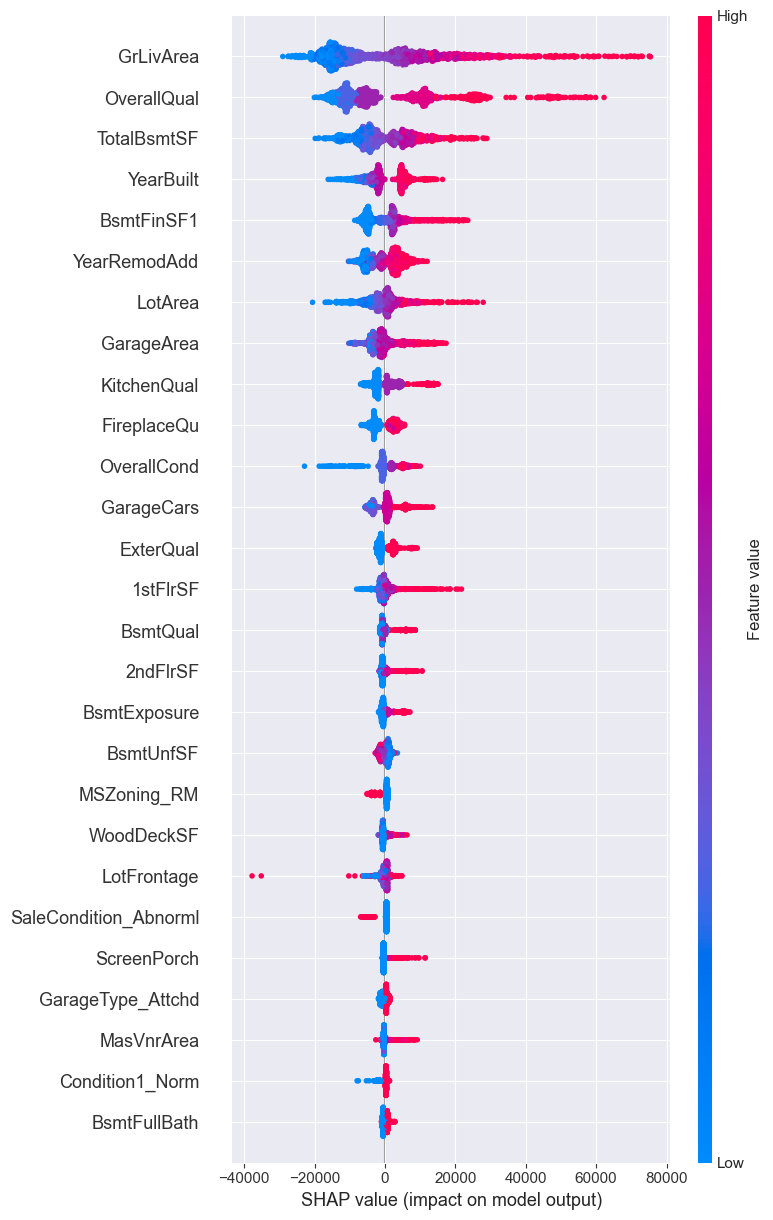

In [236]:
import shap

preprocessor = DataFramePreprocessor(
    numeric_cols=numeric_cols,
    ordinal_cols=ordinal_encode_cols,
    ohe_cols=label_encode_cols,
    label_cols=[],
    ordinal_mappings=ordinal_mappings,
    label_mappings=label_mappings,
    features_to_scale=[],
    numeric_skewed_columns = []
)
        
X_preprocessed = preprocessor.fit_transform(X)
model = XGBRegressor(objective='reg:absoluteerror', learning_rate=0.1, max_depth=3, n_estimators=300, nthread=-1, reg_alpha=1, reg_lambda=1, subsample=0.8)
model.fit(X_preprocessed, y)

explainer = shap.Explainer(model, X_preprocessed)

shap_values = explainer(X_preprocessed)

# Visualize Global Feature Importance
print("Global Feature Importance:")
shap.summary_plot(shap_values, X_preprocessed, max_display=int(X_preprocessed.shape[1] * 0.1))

In [238]:
shap_values = explainer(X_preprocessed)

shap_importances = pd.DataFrame({
    'Feature': X_preprocessed.columns,
    'Importance': np.abs(shap_values.values).mean(axis=0)
})
shap_importances = shap_importances.sort_values(by='Importance', ascending=False)

shap_importances

Feature  Importance
22             GrLivArea    15295.09
4            OverallQual    12860.54
17           TotalBsmtSF     6867.74
6              YearBuilt     4672.24
14            BsmtFinSF1     4652.08
..                   ...         ...
188  Exterior2nd_ImStucc        0.00
132      Condition2_PosN        0.00
186  Exterior2nd_CmentBd        0.00
185   Exterior2nd_CBlock        0.00
137      BldgType_2fmCon        0.00

[275 rows x 2 columns]

And Mutual Information:

In [143]:
mi_scores_dict = {}

for k in [3, 5, 10, 20]:
    mi_scores = mutual_info_regression(X_preprocessed, y, n_neighbors=k)
    mi_scores_dict[k] = pd.Series(mi_scores, index=[X_preprocessed.columns]).sort_values(ascending=False)

mi_scores_df = pd.DataFrame(mi_scores_dict)

In [144]:
mi_scores_df[5].sort_values(ascending=False)

OverallQual           0.55
GrLivArea             0.47
TotalBsmtSF           0.37
GarageCars            0.36
GarageArea            0.35
                      ... 
RoofMatl_Roll         0.00
RoofMatl_Tar&Grv      0.00
Exterior1st_BrkComm   0.00
Condition2_Artery     0.00
MSZoning_RH           0.00
Name: 5, Length: 275, dtype: float64

In [228]:
filtered_models_info['ElasticNet']

mean_importance
RoofMatl_ClyTile            363246.29
Condition2_PosN             115465.04
RoofMatl_WdShngl             54565.82
Neighborhood_StoneBr         38139.01
Neighborhood_NridgHt         36284.54
...                               ...
MSSubClass_85                    0.00
MSSubClass_90                    0.00
MSZoning_A                       0.00
Exterior2nd_AsphShn              0.00
MiscFeature_Othr                 0.00

[275 rows x 1 columns]

In [229]:
filtered_models_info['Lasso']

mean_importance
RoofMatl_ClyTile            363246.29
Condition2_PosN             115465.04
RoofMatl_WdShngl             54565.82
Neighborhood_StoneBr         38139.01
Neighborhood_NridgHt         36284.54
...                               ...
MSSubClass_85                    0.00
MSSubClass_90                    0.00
MSZoning_A                       0.00
Exterior2nd_AsphShn              0.00
MiscFeature_Othr                 0.00

[275 rows x 1 columns]

In [275]:
filtered_models_info['LinearRegression']

mean_importance
OverallQual                   0.59
GrLivArea                     0.11
TotalBsmtSF                   0.04
BsmtFinSF1                    0.03
2ndFlrSF                      0.02
...                            ...
MSZoning_RP                   0.00
Exterior1st_Stone             0.00
MSZoning_I                    0.00
MSZoning_A                    0.00
MasVnrType_None               0.00

[275 rows x 1 columns]

In [232]:
filtered_models_info['RandomForestRegressor']

mean_importance
OverallQual                   0.59
GrLivArea                     0.11
TotalBsmtSF                   0.04
BsmtFinSF1                    0.03
2ndFlrSF                      0.03
...                            ...
Electrical_Mix                0.00
MSZoning_RP                   0.00
Exterior1st_Other             0.00
MSSubClass_40                 0.00
BldgType_TwnhsI               0.00

[275 rows x 1 columns]

RandomForestRegressor focuses on numerical features only.

In [233]:
filtered_models_info['XGBRegressor']

mean_importance
ExterQual         208504484750.22
OverallQual       191600909425.78
GarageCars        110242448270.22
MSSubClass_60      46146634225.78
BsmtQual           42903022478.22
...                           ...
SaleType_VWD                  NaN
Utilities_AllPub              NaN
Utilities_ELO                 NaN
Utilities_NoSeWa              NaN
Utilities_NoSewr              NaN

[275 rows x 1 columns]

In [234]:
encoded_cat_columns = []
for col in X_preprocessed.columns:
    for cat_col in categorical_cols:
        if cat_col in col:
            encoded_cat_columns.append(col)

len(encoded_cat_columns)            

243

In [239]:
shap_importances = shap_importances.set_index('Feature')
shap_importances.index.name = None
shap_importances

Importance
GrLivArea              15295.09
OverallQual            12860.54
TotalBsmtSF             6867.74
YearBuilt               4672.24
BsmtFinSF1              4652.08
...                         ...
Exterior2nd_ImStucc        0.00
Condition2_PosN            0.00
Exterior2nd_CmentBd        0.00
Exterior2nd_CBlock         0.00
BldgType_2fmCon            0.00

[275 rows x 1 columns]

In [240]:
filtered_models_info['SHAP'] = shap_importances
filtered_models_info['MI'] = mi_scores_df[[5]].reset_index().set_index('level_0')

In [241]:
df_importances = pd.DataFrame()

for model, df_importance in filtered_models_info.items():
    print(model, df_importance.shape)
    
    df_importance = df_importance.rename(columns={df_importance.columns[0]: f'Importance_{model}'})
    
    if df_importances.empty:
        df_importances = df_importance
    else:
        df_importances = df_importances.join(
            df_importance,
            how='outer'
        )

ElasticNet (275, 1)
Lasso (275, 1)
LinearRegression (275, 1)
RandomForestRegressor (275, 1)
XGBRegressor (275, 1)
SHAP (275, 1)
MI (275, 1)


Merged importance of the models/methods:

In [242]:
df_importances = df_importances.drop(columns='Importance_LinearRegression')

Columns that are non-existing ecndoded categories in the preprocessed data:

In [252]:
zero_columns = X_preprocessed.columns[(X_preprocessed == 0).all()]
zero_columns

Index(['MSSubClass_150', 'MSZoning_A', 'MSZoning_I', 'MSZoning_RP',
       'Utilities_NoSewr', 'Utilities_ELO', 'Condition2_RRNe',
       'BldgType_TwnhsI', 'Exterior1st_Other', 'Exterior1st_PreCast',
       'Exterior2nd_PreCast', 'MasVnrType_CBlock', 'MasVnrType_None',
       'BsmtFinType1_NA', 'Functional_Sal', 'GarageType_NA', 'GarageFinish_NA',
       'Fence_NA', 'MiscFeature_Elev', 'MiscFeature_NA', 'SaleType_VWD'],
      dtype='object')

In [254]:
df_importances = df_importances.drop(index=zero_columns)
df_importances

Importance_ElasticNet  Importance_Lasso  \
1stFlrSF                          13.15             13.15   
2ndFlrSF                          16.87             16.87   
3SsnPorch                        941.66            941.66   
Alley                            140.08            140.08   
BedroomAbvGr                    5910.13           5910.13   
...                                 ...               ...   
Utilities_NoSeWa                   0.00              0.00   
WoodDeckSF                       400.94            400.94   
YearBuilt                        257.11            257.11   
YearRemodAdd                      30.53             30.53   
YrSold                           129.02            129.02   

                  Importance_RandomForestRegressor  Importance_XGBRegressor  \
1stFlrSF                                      0.02           11653421425.78   
2ndFlrSF                                      0.03           19504247125.33   
3SsnPorch                                     0.00            1026301731.56   
Alley                                         0.00             942693959.11   
BedroomAbvGr                                  0.00            2010276672.00   
...                                            ...                      ...   
Utilities_NoSeWa                              0.00                      NaN   
WoodDeckSF                                    0.00            1756691399.11   
YearBuilt                                     0.01            4563081059.56   
YearRemodAdd                                  0.01            9604824519.11   
YrSold                                        0.00             912827029.33   

                  Importance_SHAP  Importance_MI  
1stFlrSF                  1589.57           0.32  
2ndFlrSF                  1128.94           0.21  
3SsnPorch                   36.26           0.00  
Alley                      116.89           0.03  
BedroomAbvGr                84.13           0.06  
...                           ...            ...  
Utilities_NoSeWa             0.00           0.00  
WoodDeckSF                 843.13           0.10  
YearBuilt                 4672.24           0.35  
YearRemodAdd              3803.65           0.26  
YrSold                     121.94           0.02  

[254 rows x 6 columns]

In [255]:
df_importances.info()

<class 'pandas.core.frame.DataFrame'>
Index: 254 entries, 1stFlrSF to YrSold
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Importance_ElasticNet             254 non-null    float64
 1   Importance_Lasso                  254 non-null    float64
 2   Importance_RandomForestRegressor  254 non-null    float64
 3   Importance_XGBRegressor           200 non-null    float64
 4   Importance_SHAP                   254 non-null    float64
 5   Importance_MI                     254 non-null    float64
dtypes: float64(6)
memory usage: 13.9+ KB


As we can see, XGBRegressor sets np.nan for columns that are not used in splits. Let's fill na with zeroes to match other columns:

In [256]:
df_importances = df_importances.fillna(0)

In [258]:
correlation_matrix = df_importances.corr()

<Axes: >

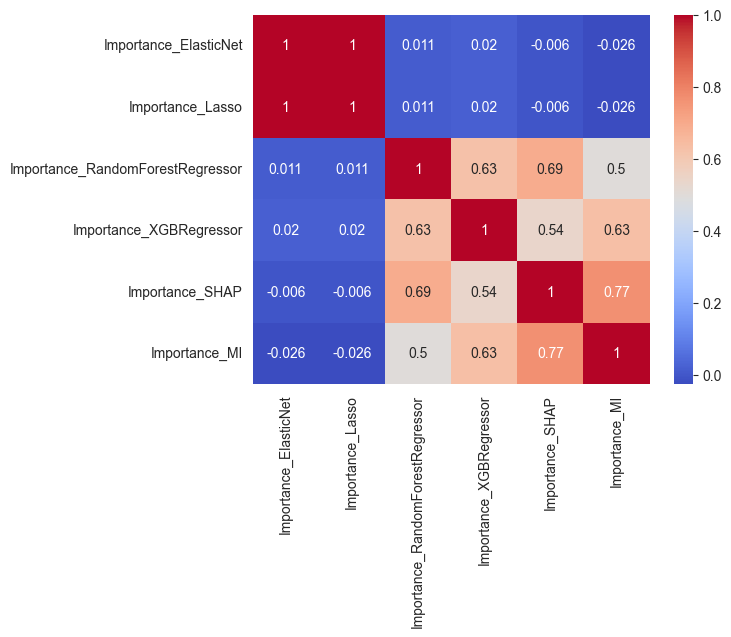

In [259]:
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

The correlation matrix highlights key differences in feature importance across algorithms. ElasticNet and Lasso show perfect correlation (r = 1.00), indicating that ElasticNet behaves like lasso with l1 coefficient close to 1. Tree-based models, such as RandomForestRegressor and XGBRegressor, and SHAP have moderate correlations (r = 0.63 to 0.69), reflecting their ability to capture non-linear interactions. SHAP strongly aligns with Mutual Information (MI) (r = 0.77), emphasizing their effectiveness in identifying non-linear dependencies. In contrast, linear models show minimal correlation with tree-based methods and SHAP, underscoring their limitations with non-linear relationships. Overall, Boosting, SHAP, and MI stand out as robust tools for understanding feature importance in complex datasets.

Let's calculate how many categorical columns are selected for each method:

In [268]:
for col in df_importances.columns:
    print(col, len(set(df_importances[col][
    (df_importances[col].notna()) & 
    (df_importances[col] != 0)
].index).intersection(set(encoded_cat_columns)))
          )

Importance_ElasticNet 113
Importance_Lasso 113
Importance_RandomForestRegressor 169
Importance_XGBRegressor 167
Importance_SHAP 125
Importance_MI 175


As expected, XGBRegressor selects more categorical features because it better captures non-linear relationships. 

## Results

Each method showcased unique strengths and limitations, especially in how they handled interactions, non-linearity, and collinearity.

Mutual Information was effective at capturing non-linear dependencies between features and the target variable, providing insights that extended beyond simple correlations. However, it struggled with handling feature interactions and collinearity, often missing redundant or complementary relationships. Despite its simplicity, MI is limited when applied to datasets with complex dependencies.

SHAP proved to be a powerful tool for feature importance analysis, especially for interpreting complex models like Gradient Boosting on trees, as it effectively combines their strengths. Beyond its technical capabilities, SHAP’s interpretability was a significant advantage, providing clear insights into how each feature contributed to the model’s predictions.

Lasso excelled in enforcing sparsity, making it particularly effective for datasets with many irrelevant features. However, its reliance on linearity limited its ability to capture more complex relationships. ElasticNet, which aims to balance sparsity and feature grouping, did not perform well in this case, reducing to Lasso on this dataset.

Gradient Boosting Regression emerged as the best-performing method in terms of predictive accuracy. Its ability to handle complex interactions and non-linear relationships demonstrated its superiority as a modeling approach for both feature selection and regression tasks. As expected, its performance showed the effectiveness of tree-based methods for datasets with diverse feature types.

It is important to recognize the feature importance scores. While it might be tempting to assume that these methods can identify which features decision-makers should manipulate to influence future outcomes, this approach can be misleading in causal inference tasks. Predictive models are not always suitable for guiding policy choices, as they often fail to establish causal relationships.